In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as grid
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import importlib as imp
import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help
import utils.tools as tools

imp.reload(fig_help)

import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.usetex'] = True
latex_engine = 'pdflatex'
latex_elements = {
    'extrapackages': r'\usepackage{physics}',
    'extrapackages': r'\usepackage{amsmath}'
}
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

USE_SYMMETRIES = True
BOUNDARY_COND = 'PBC'

base_dir = "../results/" + ("symmetries/" if USE_SYMMETRIES else "disorder/") + BOUNDARY_COND + '/'


maks_data = '/Users/rafal.swietek/Library/CloudStorage/CloudMounter-RafałŚwiętek/Shared with me/Python/Colab/ProjectsData/2023_Integrable_XYZ_XXZ/DATA/RAW/SUSY/XYZ_M/'

print(base_dir)

from filesystem import *
from entropy import *

/Users/rafal.swietek/Projects/QHamSolver/XYZ/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/symmetries/PBC/


In [3]:
parity_sectors = [-1, 1]
def get_sectors(L, hx=0, hz=0):
    translation_real_sectors = [0, L // 2] if BOUNDARY_COND == 'PBC' and L % 2 == 0 else [0]
    translation_imag_sectors = range(1, L // 2 + L % 2)
    
    spin_flip_Z_sectors = [-1, 1] if hx == 0 else [1]
    spin_flip_X_sectors = [-1, 1] if hz == 0 and (L % 2 == 0 or hx != 0) else [1]

    real_sectors = [[ks, ps, zx, zz] for ks in translation_real_sectors for ps in parity_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]
    imag_sectors = [[kx, 1, zx, zz] for kx in translation_imag_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]

    return real_sectors, imag_sectors

In [3]:
norms = np.array([0.382812, 0.574219	, 0.765625	, 0.957031	,  1.14844	,  1.33984])

# OPERATOR DEFINITIONS

$$\Large S_0=\frac{1}{L}\sum_{\ell,\ell'=1}^LS^+_\ell S^-_{\ell'}$$
$$\Large K_\ell=S^+_\ell S^-_{\ell+1}+S^-_{\ell}S^+_{\ell+1}$$
$$\Large K=\frac{1}{\sqrt{L}}\sum_{\ell=1}^LS^+_\ell S^-_{\ell+1}+S^-_{\ell} S^+_{\ell+1}$$
$$\Large K^{(2)}_\ell=S^+_\ell S^-_{\ell+2}+S^-_{\ell}S^+_{\ell+2}$$
$$\Large K^{(2)}=\frac{1}{\sqrt{L}}\sum_{\ell=1}^LS^+_\ell S^-_{\ell+2}+S^-_{\ell}S^+_{\ell+2}$$
$$\Large U_\ell=S^z_\ell S^z_{\ell+1}$$
$$\Large U=\frac{1}{\sqrt{L}}\sum_{\ell=1}^LS^z_\ell S^z_{\ell+1}$$
$$\Large J_E=\frac{1}{L}\sum_\ell j^E_\ell=-\frac{1}{L}\sum_{\ell=1}^L\sum_{\alpha,\beta,\gamma\in\{x,y,z\}}J_\alpha J_\gamma \epsilon_{\alpha\beta\gamma}S^\alpha_{\ell-1}S^\beta_\ell S^\gamma_{\ell+1}$$
$$\Large \begin{split}j^E_\ell=&J_xJ_y\left(S^x_{\ell-1}S^y_{\ell+1}S^z_\ell-S^y_{\ell-1}S^x_{\ell+1}S^z_\ell\right)\\+&J_yJ_z\left(S^y_{\ell-1}S^z_{\ell+1}S^x_\ell-S^z_{\ell-1}S^y_{\ell+1}S^x_\ell\right)\\+&J_zJ_x\left(S^z_{\ell-1}S^x_{\ell+1}S^y_\ell-S^x_{\ell-1}S^z_{\ell+1}S^y_\ell\right)\end{split}$$


$$\Large \begin{array}{c}j^E_{\ell+1}=\left(\vec{s}_{\ell-1}\times\vec{\mathcal{S}}_{\ell}\right)\cdot\vec{s}_{\ell+1}\\ s^\alpha_\ell=\sqrt{J_\alpha} S^\alpha_\ell\qquad\mathcal{S}^\alpha_\ell=\sqrt{\frac{J_xJ_yJ_z}{J_\alpha}} S^\alpha_\ell\end{array}$$

$$\Large \begin{split}j^E_{\ell+1}=&J_xJ_y\left(S^x_{\ell}S^y_{\ell+2}-S^y_{\ell}S^x_{\ell+2}\right)S^z_{\ell+1}\\+J_z&\left(J_yS^y_{\ell}S^x_{\ell+1}-J_xS^x_{\ell}S^y_{\ell+1}\right)S^z_{\ell+2}\\+J_z&\left(J_xS^x_{\ell+2}S^y_{\ell+1}-J_yS^y_{\ell+2}S^x_{\ell+1}\right)S^z_{\ell}\end{split}$$

# OBC

$$\Large S_0=\frac{\sqrt{2}}{L}\sum_{\ell,\ell'=1}^LS^+_\ell S^-_{\ell'}$$
$$\Large K=\sqrt{\frac{2}{L-1}}\sum_{\ell=1}^{L-1}S^+_\ell S^-_{\ell+1}+S^-_{\ell} S^+_{\ell+1}$$
$$\Large K^{(2)}=\sqrt{\frac{2}{L-2}}\sum_{\ell=1}^{L-2}S^+_\ell S^-_{\ell+2}+S^-_{\ell}S^+_{\ell+2}$$
$$\Large U=\frac{4}{\sqrt{L-1}}\sum_{\ell=1}^{L-1}S^z_\ell S^z_{\ell+1}$$
$$\Large J_E=\frac{4\sqrt{2}}{\sqrt{L-2}\mathcal{N}}\sum_\ell j^E_\ell=\frac{4\sqrt{2}}{\sqrt{L-2}\mathcal{N}}\sum_{\ell=2}^{L-1}\sum_{\alpha,\beta,\gamma\in\{x,y,z\}}J_\alpha J_\gamma \epsilon_{\alpha\beta\gamma}S^\alpha_{\ell-1} S^\beta_{\ell+1}S^\gamma_\ell$$
$$\Large \begin{split}\mathcal{N}&=\sqrt{(J_xJ_y)^2+(J_yJ_z)^2+(J_zJ_x)^2}\\ j^E_\ell=&J_xJ_y\left(S^x_{\ell-1}S^y_{\ell+1}S^z_\ell-S^y_{\ell-1}S^x_{\ell+1}S^z_\ell\right)\\+&J_yJ_z\left(S^y_{\ell-1}S^z_{\ell+1}S^x_\ell-S^z_{\ell-1}S^y_{\ell+1}S^x_\ell\right)\\+&J_zJ_x\left(S^z_{\ell-1}S^x_{\ell+1}S^y_\ell-S^x_{\ell-1}S^z_{\ell+1}S^y_\ell\right)\end{split}$$



--------------------------------- XYZ
$\mathcal{O}=K$ [-0.08051225  1.00102684] [14 16 18 20]
$\mathcal{O}=K^{(2)}$ [-0.15395012  1.35332683] [14 16 18 20]
$\mathcal{O}=U$ [-0.42775017  2.53656385] [14 16 18 20]
 [-1.07972895 12.791116  ] [14 16 18 20]
 [-1.66432898 48.50589971] [14 16 18 20]
 [-1.6840322  43.90830918] [14 16 18 20]
 [ -2.04425101 113.31541248] [14 16 18 20]

--------------------------------- XXZ
 [-0.19853484  1.71184625] [16 18 20 22]
 [-0.03757559  1.09809059] [16 18 20 22]
 [-0.19868417  1.74421203] [16 18 20 22]
$\mathcal{O}=S_0$ [-1.0790505  16.97168266] [16 18 20 22]
$\mathcal{O}=K_{L/2}$ [-1.27710029 22.91686403] [16 18 20 22]
$\mathcal{O}=K^{(2)}_{L/2}$ [-1.35669791 27.59716303] [16 18 20 22]
$\mathcal{O}=U_{L/2}$ [-1.60624392 48.87837569] [16 18 20 22]


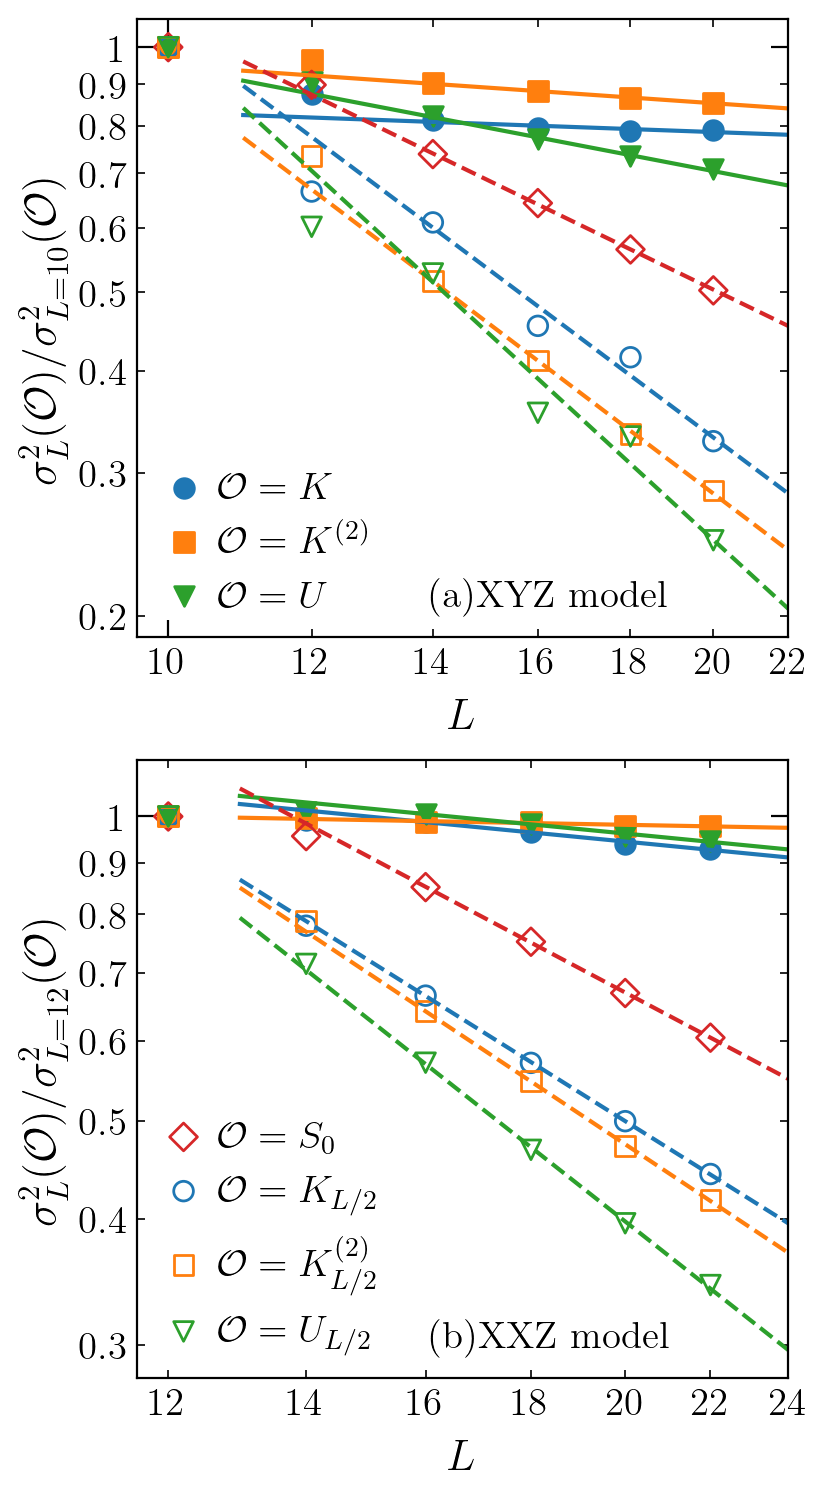

In [122]:
BOUNDARY_COND = 'OBC'
base_dir = "../results/" + ("symmetries/" if USE_SYMMETRIES else "disorder/") + BOUNDARY_COND + '/'

fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(4.2,9), dpi = 200)

L=22
J1=1.0
d1=0.2
e1=0.2

REAL_SECTORS = 0


def plot_data(axis, x, y, legend = False, label = "", empty=False):
    y = y / y[0]
    colo = next(colors)
    
    axis.scatter(x, rescale(sizes, y), marker=next(markers), color = colo, label=label, facecolor='None' if empty else colo, s=50)

    linestyle = '--' if empty else '-'
    if not any(np.isnan(y)) and not (all(np.abs(y) < 1e-14)):
        pars, pconv = fit(power_law,
                        xdata = x[-4:],
                        ydata = y[-4:])
        
        print(label, pars, x[-4:])
        xval = np.linspace(min(x[-5:])-1, max(x)+2, 100)
        axis.plot(xval, power_law(xval, *pars), ls=linestyle, color=colo)#, label=r"$\sim L^{%.2f}$"%pars[0])
    

print("\n--------------------------------- XYZ")
# XYZ
sizes = (np.arange(14, 25, 2) if REAL_SECTORS else np.arange(14, 24, 2)) if BOUNDARY_COND == 'PBC' else np.arange(10, 21, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)


folder_base = f'./matrix_elements/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

filenamee = folder + (f'variance_eta={e1},delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'variance_eta={e1},delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    print(filenamee)


# ----------------- RESCALE DATA
Int = Int * sizes * 16 / (sizes - 1)
Kin = Kin * sizes * 2 / (sizes - 1)
Kin2 = Kin2 * sizes * 2 / (sizes - 1)
Sq0 = Sq0 * np.sqrt(2)

# -----------------


colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[0], sizes, Kin     , label=r"$\mathcal{O}=K$")
plot_data(axis[0], sizes, Kin2    , label=r"$\mathcal{O}=K^{(2)}$")
plot_data(axis[0], sizes, Int     , label=r"$\mathcal{O}=U$")
plot_data(axis[0], sizes, Sq0     , empty=True)#, label=r"$S_0$")

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[0], sizes, Kin_loc , empty=True)#, label=r"$K_{L/2}$", empty=True)
plot_data(axis[0], sizes, Kin2_loc, empty=True)#, label=r"$K^{(2)}_{L/2}$", empty=True)
plot_data(axis[0], sizes, Int_loc , empty=True)#, label=r"$U_{L/2}$", empty=True)
# plot_data(axis, sizes, rescale(sizes, jE)      , label=r"$j^E$")



fig_help.set_plot_elements(axis[0], ylabel=r"$\sigma^2_L(\mathcal{O})/\sigma^2_{L=%d}(\mathcal{O})$"%sizes[0], xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log', xlim=(None, sizes[-1]+2))
axis[0].legend(frameon=0, fontsize=14, loc='lower left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))

   
print("\n--------------------------------- XXZ") 
# XXZ
d1=0.55
sizes = (np.arange(14, 26, 2) if REAL_SECTORS else np.arange(14, 26, 2)) if BOUNDARY_COND == 'PBC' else np.arange(12, 23, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)


folder_base = f'./matrix_elements/XXZ/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

filenamee = folder + (f'variance_delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'variance_delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    print(filenamee)


# ----------------- RESCALE DATA
Int = Int * sizes * 16 / (sizes - 1)
Kin = Kin * sizes * 2 / (sizes - 1)
Kin2 = Kin2 * sizes * 2 / (sizes - 1)
Sq0 = Sq0 * np.sqrt(2)

# -----------------


colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[1], sizes, Kin     )#, label=r"$K$")
plot_data(axis[1], sizes, Kin2    )#, label=r"$K^{(2)}$")
plot_data(axis[1], sizes, Int     )#, label=r"$U$")
plot_data(axis[1], sizes, Sq0     , label=r"$\mathcal{O}=S_0$", empty=True)

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[1], sizes, Kin_loc , label=r"$\mathcal{O}=K_{L/2}$", empty=True)
plot_data(axis[1], sizes, Kin2_loc, label=r"$\mathcal{O}=K^{(2)}_{L/2}$", empty=True)
plot_data(axis[1], sizes, Int_loc , label=r"$\mathcal{O}=U_{L/2}$", empty=True)
# plot_data(axis, sizes, rescale(sizes, jE)      , label=r"$j^E$")

yscale = 'log'
xscale = 'log'

fig_help.set_plot_elements(axis[1], ylabel=r"$\sigma^2_L(\mathcal{O})/\sigma^2_{L=%d}(\mathcal{O})$"%sizes[0], xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log', xlim=(None, sizes[-1]+2))
axis[1].legend(frameon=0, fontsize=14, loc='lower left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))

# axis.set_xticks(sizes)

for ax in axis:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis[0].set_xlim(None, 22)
axis[1].set_xlim(None, 24)

fig.subplots_adjust(wspace = 0.2, hspace=0.2)

axis[0].annotate("(a)XYZ model", fontsize=14, xy=(0.45, 0.05), xycoords='axes fraction')
axis[1].annotate("(b)XXZ model", fontsize=14, xy=(0.45, 0.05), xycoords='axes fraction')
# fig.subplots_adjust(wspace = 0.3, hspace=0.2)
plt.savefig("Fig8.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("Fig8.png", bbox_inches = 'tight', pad_inches=0.02)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


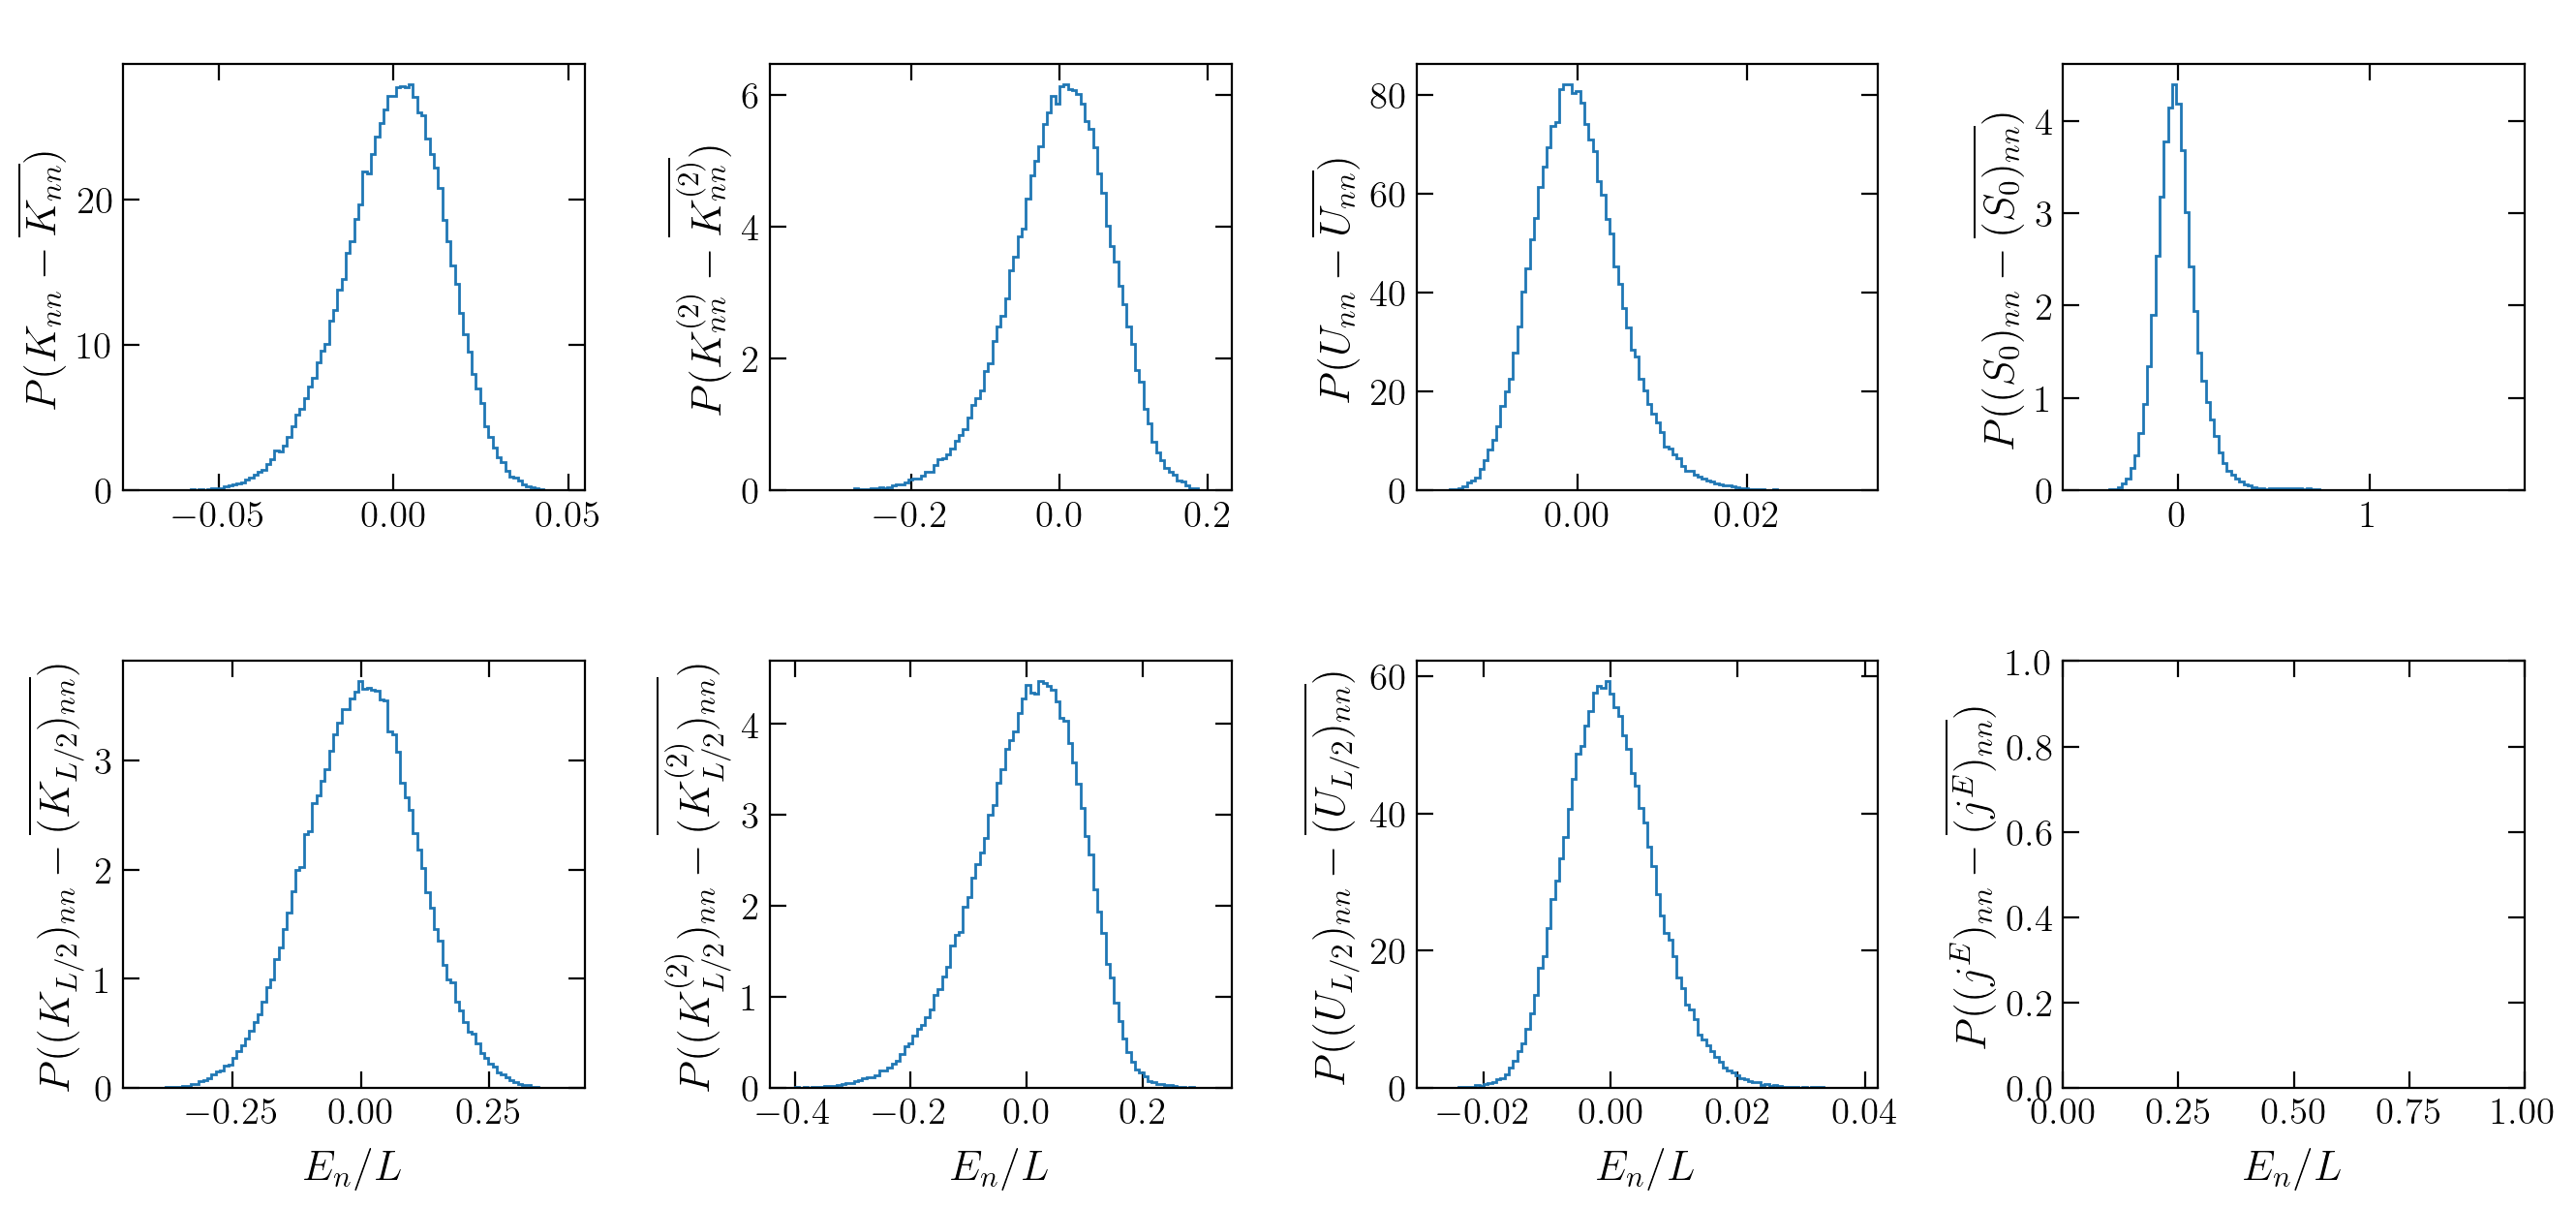

In [130]:
fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,7), dpi = 200)

axis_top = axes[0, :]
axis_bot = axes[1, :]
# axis_bot[-1].axis('off')


L=20
J1=1.0
d1=0.2
e1=0.2

ks=1
ps=1
zxs=1
zzs=1

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

window=50

L = 20

# for L in sizes[::-1]:
    # ks = L//2
name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
data_type = 'float' if ks == 0 or ks == L / 2 else 'complex'

if exists(name):
    with h5py.File(name, "r") as file:
        energies = np.array(file.get('energies')[0]) - L/8 * (3+e1**2)
        
        Sq0 = np.array(file.get('Sq0')[0])
        jE = np.array(file.get('jE')[0]).view('complex')
        if any(np.abs(np.imag(jE)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
        else:                                   jE = np.real(jE)
        

        Kin = np.array(file.get('Kin')[0])
        Kin2 = np.array(file.get('Kin2')[0])
        Int = np.array(file.get('Int')[0])
        
        Kin_loc = np.array(file.get('Kin_loc')[0])
        Kin2_loc = np.array(file.get('Kin2_loc')[0])
        Int_loc = np.array(file.get('Int_loc')[0])

        Sq0      = (get_fluctuations(Sq0,         bucket_size=window, type='mean'))
        jE       = (get_fluctuations(jE,          bucket_size=window, type='mean'))
        Kin      = (get_fluctuations(Kin,         bucket_size=window, type='mean'))
        Kin_loc  = (get_fluctuations(Kin_loc,     bucket_size=window, type='mean'))
        Kin2     = (get_fluctuations(Kin2,        bucket_size=window, type='mean'))
        Kin2_loc = (get_fluctuations(Kin2_loc,    bucket_size=window, type='mean'))
        Int      = (get_fluctuations(Int,         bucket_size=window, type='mean'))
        Int_loc  = (get_fluctuations(Int_loc,     bucket_size=window, type='mean'))
        
        for ijk, op in enumerate([Kin, Kin2, Int, Sq0]):
            hist, bins = np.histogram(op, bins=100, normed=True)
            axis_top[ijk].stairs(hist, bins)
        
        for ijk, op in enumerate([Kin_loc, Kin2_loc, Int_loc]):
            hist, bins = np.histogram(op, bins=100, normed=True)
            axis_bot[ijk].stairs(hist, bins)
        
        # if L >= sizes[-3]:
        #     hist, edges = np.histogram(energies / L, bins=int(L**2/10), normed=True)
        #     axis_bot[3].stairs(hist, edges, label=r"$L=%d$"%L)
        #     x_min = min(edges)
        #     x_max = max(edges)
else:
    print(name)

# aa = np.linspace(x_min, x_max, 1000)
# axis_bot[3].plot(aa, 1 / np.sqrt(2*np.pi) * np.exp(-aa**2 / 2), ls='--', c='k')

def make_title(title):
    return r"$P(%s-\overline{%s})$"%(title, title)

scale = 'linear'
fig_help.set_plot_elements(axis_top[0], ylabel=make_title("K_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_top[1], ylabel=make_title("K^{(2)}_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_top[2], ylabel=make_title("U_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

fig_help.set_plot_elements(axis_top[3], ylabel=make_title("(S_0)_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

fig_help.set_plot_elements(axis_bot[0], ylabel=make_title("(K_{L/2})_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[1], ylabel=make_title("(K^{(2)}_{L/2})_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[2], ylabel=make_title("(U_{L/2})_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[3], ylabel=make_title("(j^E)_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)

axis_top[0].legend(frameon=0, fontsize=14, loc='upper left', ncol=8, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01, 1.15))
axis_bot[3].legend(frameon=0, fontsize=14, loc='upper left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01, 1.02))

fig.subplots_adjust(wspace = 0.4, hspace=0.4)

# PBC

$$\Large S_0=\frac{\sqrt{2}}{L}\sum_{\ell,\ell'=1}^LS^+_\ell S^-_{\ell'}$$
$$\Large K=\sqrt{\frac{2}{L}}\sum_{\ell=1}^LS^+_\ell S^-_{\ell+1}+S^-_{\ell} S^+_{\ell+1}$$
$$\Large K^{(2)}=\sqrt{\frac{2}{L}}\sum_{\ell=1}^LS^+_\ell S^-_{\ell+2}+S^-_{\ell}S^+_{\ell+2}$$
$$\Large U=\frac{4}{\sqrt{L}}\sum_{\ell=1}^LS^z_\ell S^z_{\ell+1}$$
$$\Large J_E=\frac{4\sqrt{2}}{\sqrt{L}\mathcal{N}}\sum_\ell j^E_\ell=\frac{4\sqrt{2}}{\sqrt{L}\mathcal{N}}\sum_{\ell=1}^L\sum_{\alpha,\beta,\gamma\in\{x,y,z\}}J_\alpha J_\gamma \epsilon_{\alpha\beta\gamma}S^\alpha_{\ell-1} S^\beta_{\ell+1}S^\gamma_\ell$$
$$\Large \begin{split}\mathcal{N}&=\sqrt{(J_xJ_y)^2+(J_yJ_z)^2+(J_zJ_x)^2}\\ j^E_\ell=&J_xJ_y\left(S^x_{\ell-1}S^y_{\ell+1}S^z_\ell-S^y_{\ell-1}S^x_{\ell+1}S^z_\ell\right)\\+&J_yJ_z\left(S^y_{\ell-1}S^z_{\ell+1}S^x_\ell-S^z_{\ell-1}S^y_{\ell+1}S^x_\ell\right)\\+&J_zJ_x\left(S^z_{\ell-1}S^x_{\ell+1}S^y_\ell-S^x_{\ell-1}S^z_{\ell+1}S^y_\ell\right)\end{split}$$



--------------------------------- XYZ
$K$ [-0.46371889  3.55042086] [16 18 20 22]
$K^{(2)}$ [-0.30690598  2.10474784] [16 18 20 22]
$U$ [-0.61120291  4.77627759] [16 18 20 22]
 [-1.48128229 50.58872886] [16 18 20 22]
$j^E$ [-0.94890917 12.04769674] [16 18 20 22]
 [-1.43469072 46.49389783] [16 18 20 22]
 [-1.24929513 25.36263985] [16 18 20 22]
 [-1.55838023 58.36174177] [16 18 20 22]

--------------------------------- XXZ
 [-0.31493393  2.33017448] [18 20 22 24]
 [-0.14546214  1.62703057] [18 20 22 24]
 [-0.2974206   2.35276047] [18 20 22 24]
$S_0$ [-1.09058777 20.56556912] [18 20 22 24]
 [-1.02759886 14.6149399 ] [18 20 22 24]
$K_{L/2}$ [-1.27003936 29.17143621] [18 20 22 24]
$K^{(2)}_{L/2}$ [-1.0960207  20.09108703] [18 20 22 24]
$U_{L/2}$ [-1.2506189  29.28506882] [18 20 22 24]


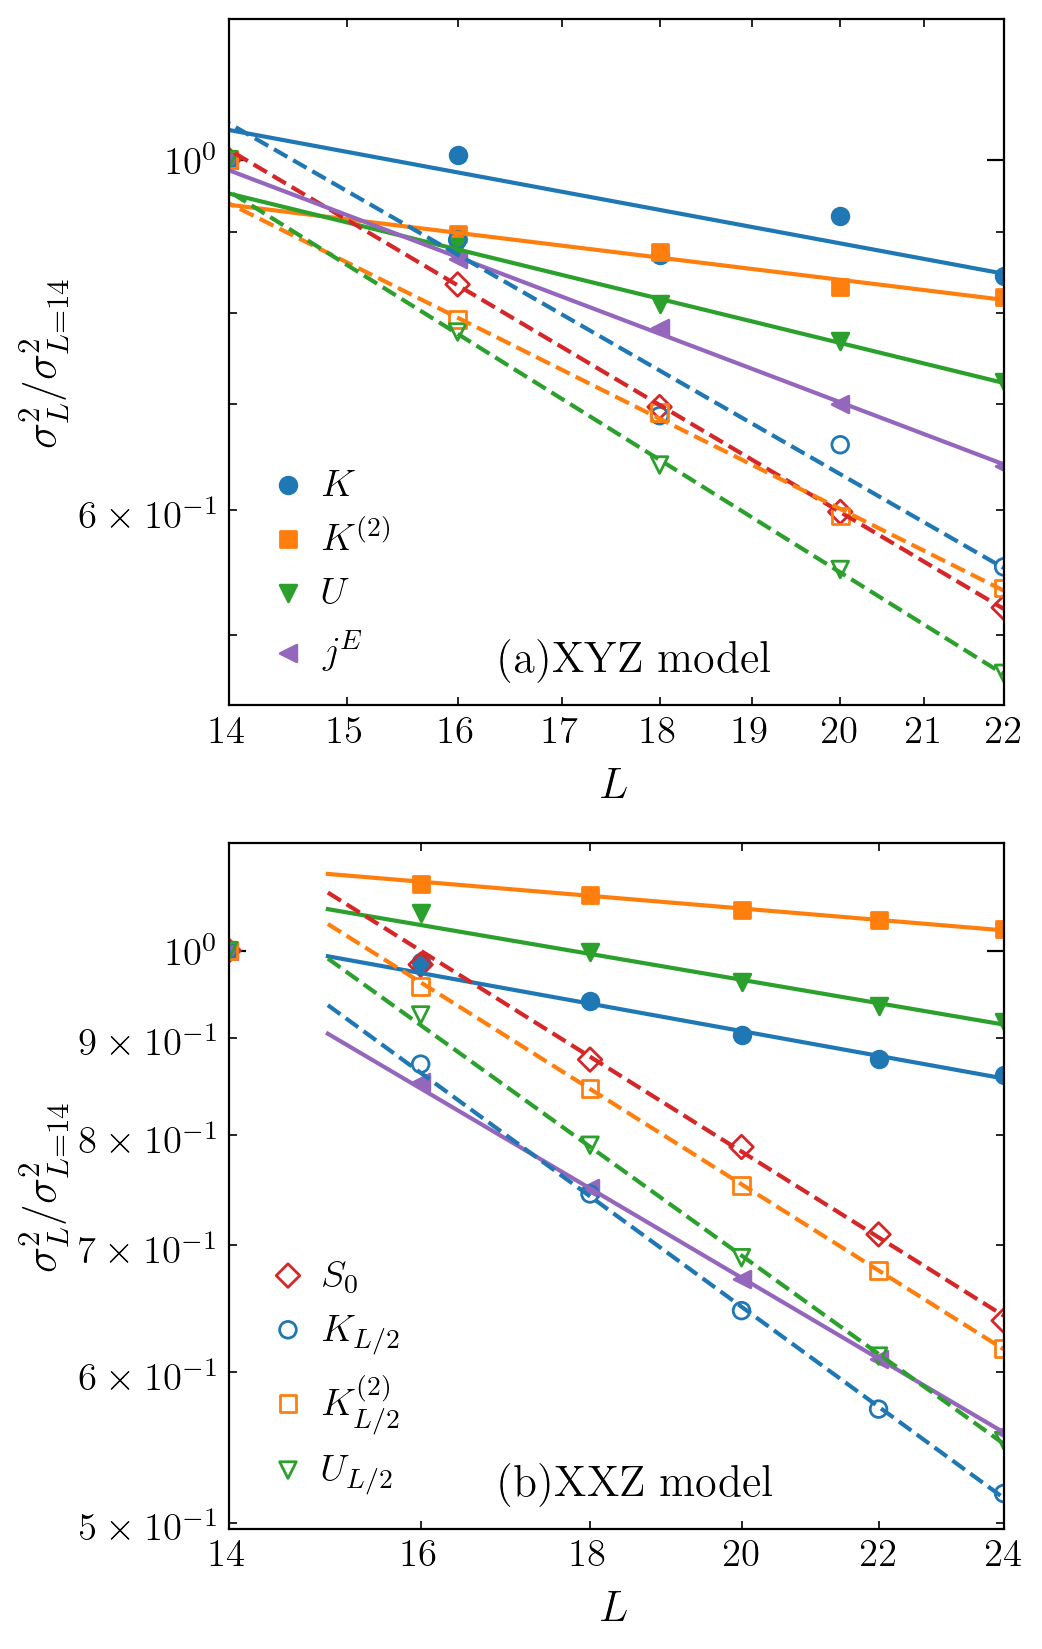

In [101]:
BOUNDARY_COND = 'PBC'
base_dir = "../results/" + ("symmetries/" if USE_SYMMETRIES else "disorder/") + BOUNDARY_COND + '/'

fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(5,10), dpi = 200)

L=22
J1=1.0
d1=0.2
e1=0.2

REAL_SECTORS = 0


def plot_data(axis, x, y, legend = False, label = "", empty=False):
    y = y / y[0]
    colo = next(colors)
    
    axis.scatter(x, rescale(sizes, y), marker=next(markers), color = colo, label=label, facecolor='None' if empty else colo)

    linestyle = '--' if empty else '-'
    if not any(np.isnan(y)) and not (all(np.abs(y) < 1e-14)):
        pars, pconv = fit(power_law,
                        xdata = x[-4:],
                        ydata = y[-4:])
        
        print(label, pars, x[-4:])
        xval = np.linspace(min(x[-5:])-1, max(x), 100)
        axis.plot(xval, power_law(xval, *pars), ls=linestyle, color=colo)#, label=r"$\sim L^{%.2f}$"%pars[0])
    

print("\n--------------------------------- XYZ")
# XYZ
sizes = (np.arange(14, 25, 2) if REAL_SECTORS else np.arange(14, 24, 2)) if BOUNDARY_COND == 'PBC' else np.arange(10, 21, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)


folder_base = f'./matrix_elements/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

filenamee = folder + (f'variance_eta={e1},delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'variance_eta={e1},delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    print(filenamee)


# ----------------- RESCALE DATA
Int = Int * sizes * 16 / (sizes - 1)
Kin = Kin * sizes * 2 / (sizes - 1)
Kin2 = Kin2 * sizes * 2 / (sizes - 1)
Sq0 = Sq0 * np.sqrt(2)

# -----------------


colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[0], sizes, Kin     , label=r"$K$")
plot_data(axis[0], sizes, Kin2    , label=r"$K^{(2)}$")
plot_data(axis[0], sizes, Int     , label=r"$U$")
plot_data(axis[0], sizes, Sq0     , empty=True)#, label=r"$S_0$")
plot_data(axis[0], sizes, jE      , label=r"$j^E$")

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[0], sizes, Kin_loc , empty=True)#, label=r"$K_{L/2}$", empty=True)
plot_data(axis[0], sizes, Kin2_loc, empty=True)#, label=r"$K^{(2)}_{L/2}$", empty=True)
plot_data(axis[0], sizes, Int_loc , empty=True)#, label=r"$U_{L/2}$", empty=True)
# plot_data(axis, sizes, rescale(sizes, jE)      , label=r"$j^E$")



fig_help.set_plot_elements(axis[0], ylabel=r"$\sigma^2_L/\sigma^2_{L=%d}$"%sizes[0], xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log', xlim=(sizes[0], sizes[-1]))
axis[0].legend(frameon=0, fontsize=14, loc='lower left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.0,-0.0))

   
print("\n--------------------------------- XXZ") 
# XXZ
d1=0.55
sizes = (np.arange(14, 26, 2) if REAL_SECTORS else np.arange(14, 26, 2)) if BOUNDARY_COND == 'PBC' else np.arange(12, 23, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)


folder_base = f'./matrix_elements/XXZ/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

filenamee = folder + (f'variance_delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'variance_delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    print(filenamee)


# ----------------- RESCALE DATA
Int = Int * sizes * 16 / (sizes - 1)
Kin = Kin * sizes * 2 / (sizes - 1)
Kin2 = Kin2 * sizes * 2 / (sizes - 1)
Sq0 = Sq0 * np.sqrt(2)

# -----------------


colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[1], sizes, Kin     )#, label=r"$K$")
plot_data(axis[1], sizes, Kin2    )#, label=r"$K^{(2)}$")
plot_data(axis[1], sizes, Int     )#, label=r"$U$")
plot_data(axis[1], sizes, Sq0     , label=r"$S_0$", empty=True)
plot_data(axis[1], sizes, jE      )#, label=r"$j^E$")

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis[1], sizes, Kin_loc , label=r"$K_{L/2}$", empty=True)
plot_data(axis[1], sizes, Kin2_loc, label=r"$K^{(2)}_{L/2}$", empty=True)
plot_data(axis[1], sizes, Int_loc , label=r"$U_{L/2}$", empty=True)

yscale = 'log'
xscale = 'log'

fig_help.set_plot_elements(axis[1], ylabel=r"$\sigma^2_L/\sigma^2_{L=%d}$"%sizes[0], xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log', xlim=(sizes[0], sizes[-1]))
axis[1].legend(frameon=0, fontsize=14, loc='lower left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.0,-0.0))

# axis.set_xticks(sizes)

for ax in axis:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

fig.subplots_adjust(wspace = 0.2, hspace=0.2)

axis[0].annotate("(a)XYZ model", fontsize=16, xy=(0.35, 0.05), xycoords='axes fraction')
axis[1].annotate("(b)XXZ model", fontsize=16, xy=(0.35, 0.05), xycoords='axes fraction')
# fig.subplots_adjust(wspace = 0.3, hspace=0.2)
plt.savefig("MatrixElements_variance_PBC.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("MatrixElements_variance_PBC.png", bbox_inches = 'tight', pad_inches=0.02)

# PREAMBLE

In [126]:
a = np.array([-1, 2, 3, 4, 6, 14.22])
print(a, -a - 2.0)

[-1.    2.    3.    4.    6.   14.22] [ -1.    -4.    -5.    -6.    -8.   -16.22]


In [204]:

L=14
J1=1.0
d1=0.2
e1=0.2

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec


Sq0_matelem = []
Kin_matelem = []
Kin_loc_matelem = []
dim_tot = 0
energies = []
states = []
sectors = []

r = 0
counter = 0
for [ks, ps, zxs, zzs] in sects:
# for [ks, ps, zxs, zzs] in [[1,1,-1,-1]]:
    name = base_dir + 'DIAGONALIZATION/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            E = np.array(file.get('energies')[0])
            dim = E.size
            # print(ks, ps, zxs, zzs, E.size)

            gaps = np.diff(E)
            ratio = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])
            num = int(dim // 2)

            E_av = np.mean(E)
            index_meanE = min(range(len(E)), key=lambda i: abs(E[i] - E_av))
            
            my_min = int(index_meanE - num / 2)
            if my_min < 0: my_min = 0;  

            my_max = int(index_meanE + num / 2) 
            if my_max >= dim: my_max = dim

            r += np.mean(ratio[my_min : my_max])
            counter += 1
            V = np.array(file.get('eigenvectors')).view('complex')
            
            energies = [*energies, *E] if ks == 0 or (ks == L // 2 and L%2 == 0) else [*energies, *E, *E]
            for psi in V:
                states.append(psi)
            
            if not (ks == 0 or (ks == L // 2 and L%2 == 0)):
                # print("aa")
                for psi in V:
                    states.append(psi.conj())

            sec = ['k=%d,p=%d,zx=%d,zz=%d'%(ks, ps, zxs, zzs)] * dim
            sectors = [*sectors, *sec]

            if not (ks == 0 or (ks == L // 2 and L%2 == 0)):
                sec = ['k=%d,p=%d,zx=%d,zz=%d'%(L-ks, ps, zxs, zzs)] * dim
                sectors = [*sectors, *sec]
    else:
        print(name)

print("Gap Ratio:", r / counter)
energies = np.array(energies)
states = np.array(states)
sectors = np.array(sectors)

# jE = JE.toarray()
# for n, E in enumerate(energies):
#     psi_n = sparse.csr_matrix(states[n])
#     psi_m = sparse.csr_matrix(states[n]).T.conj()
#     psi_n = np.array(states[n])
#     # print(psi_n.shape, JE.shape, psi_m.shape)
#     # if np.abs(psi_n.dot(JE.dot(psi_m))) > 1e-16:        
#     print(E, sectors[n], n, "JE",  psi_n.conj().T @ (jE @ psi_n.conj()) / L, psi_n.conj().T @ (psi_n).conj()   )


from operator import itemgetter
sorted_idx, energies = zip(*sorted(enumerate(energies), key=itemgetter(1)))
sorted_idx = np.array(sorted_idx).astype(int)
states = states[sorted_idx]
sectors = sectors[sorted_idx]

energies = np.round(energies, 14)

_, indices, counts = np.unique(energies, return_index=True, return_counts=True)
non_deg_idx = []
deg_idx = []
for new_iii, idx in enumerate(indices):
    if counts[new_iii] == 1:
        for _ in range(counts[new_iii]):
            non_deg_idx.append(idx)
    else:
        deg_loc = []
        for _ in range(counts[new_iii]):
            deg_loc.append(idx)
            idx += 1
        deg_idx.append(deg_loc)

sig_x = np.array([[0, 1], [1, 0]])
print(deg_idx)

Gap Ratio: 0.38684752065495276
[[4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [39, 40], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [63, 64], [65, 66], [67, 68], [69, 70], [71, 72], [73, 74], [76, 77], [78, 79], [80, 81], [82, 83], [84, 85], [86, 87], [88, 89], [90, 91], [92, 93], [94, 95], [98, 99], [100, 101], [102, 103], [104, 105], [106, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 117], [118, 119], [120, 121], [122, 123], [124, 125], [126, 127], [128, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 141], [142, 143], [144, 145], [146, 147], [148, 149], [150, 151], [152, 153], [154, 155], [156, 157], [158, 159], [160, 161], [162, 163], [164, 165], [166, 167], [168, 169], [172, 173], [174, 175], [176, 177], [178, 179], [180, 181], [182, 183], [184, 185], [186, 187], [188, 18

In [4]:
up = np.array([[1], [0]])
down = np.array([[0], [1]])
from scipy import sparse
from scipy.sparse import kron as kron
from scipy.sparse import eye as eye
# from scipy.sparse import 

sig_x = sparse.csr_matrix(np.array([[0, 1], [1, 0]]))
sig_y = sparse.csr_matrix(np.array([[0, -1j], [1j, 0]]))
sig_z = sparse.csr_matrix(np.array([[1, 0], [0, -1]]))
sig_p = sparse.csr_matrix(np.array([[0, 1], [0, 0]]))
sig_m = sparse.csr_matrix(np.array([[0, 0], [1, 0]]))

print(kron(eye(1), sig_z))
print(sig_x.dot(sig_p.dot(sig_x)))

  (0, 0)	1.0
  (0, 1)	0.0
  (1, 0)	0.0
  (1, 1)	-1.0
  (1, 0)	1


In [21]:

def _dim(x):
    return int(2**x)

L=4

print("L\tK\t\t\tK2\t\t\tU\t\t\tU2\t\t\tS0\t\t\tjE")
for L in range(4, 19, 2):
    S0 = kron(sig_p @ sig_m, eye(2**(L - 1)))
    sig_pm_1 = kron(sig_p, sig_m)
    sig_pm_2 = kron(sig_p, kron(eye(2), sig_m))
    sig_zz = kron(sig_z, sig_z)
    sig_zz2 = kron(sig_z, kron(eye(2), sig_z))

    e1=0.2
    d1=0.2
    Jx = 1 - e1
    Jy = 1 + e1
    Jz = d1
    # j=0
    JE = Jx * Jy * ( kron(kron(kron(sig_z, sig_y), eye(2**(L - 3))), sig_x) - kron(kron(kron(sig_z, sig_x), eye(2**(L - 3))), sig_y) )
    JE += Jy * Jz * ( kron(kron(kron(sig_x, sig_z), eye(2**(L - 3))), sig_y) - kron(kron(kron(sig_x, sig_y), eye(2**(L - 3))), sig_z) )
    JE += Jz * Jx * ( kron(kron(kron(sig_y, sig_x), eye(2**(L - 3))), sig_z) - kron(kron(kron(sig_y, sig_z), eye(2**(L - 3))), sig_x) )
    # j=1
    JE += Jx * Jy * kron( kron(kron(sig_x, sig_z), sig_y) - kron(kron(sig_y, sig_z), sig_x), eye(_dim(L-3)) )
    JE += Jy * Jz * kron( kron(kron(sig_y, sig_x), sig_z) - kron(kron(sig_z, sig_x), sig_y), eye(_dim(L-3)) )
    JE += Jz * Jx * kron( kron(kron(sig_z, sig_y), sig_x) - kron(kron(sig_x, sig_y), sig_z), eye(_dim(L-3)) )


    U = kron(sig_zz, eye(2**(L - 2)))
    U2 = kron(sig_zz2, eye(2**(L - 3)))

    K = kron(sig_pm_1, eye(2**(L - 2)))
    K2 = kron(sig_pm_2, eye(2**(L - 3)))
    U_loc = None
    K_loc = None
    K2_loc = None

    for i in range(1, L - 1):
        U += kron(eye(_dim(i)), kron(sig_zz, eye(_dim(L-i-2))))
        K += kron(eye(_dim(i)), kron(sig_pm_1, eye(_dim(L-i-2))))
        if i > 1:
            JE += Jx * Jy * kron(eye(_dim(i-1)), kron( kron(kron(sig_x, sig_z), sig_y) - kron(kron(sig_y, sig_z), sig_x), eye(_dim(L-i-2)) ))
            JE += Jy * Jz * kron(eye(_dim(i-1)), kron( kron(kron(sig_y, sig_x), sig_z) - kron(kron(sig_z, sig_x), sig_y), eye(_dim(L-i-2)) ))
            JE += Jz * Jx * kron(eye(_dim(i-1)), kron( kron(kron(sig_z, sig_y), sig_x) - kron(kron(sig_x, sig_y), sig_z), eye(_dim(L-i-2)) ))
        
        if i < L-2:
            U2 += kron(eye(_dim(i)), kron(sig_zz2, eye(_dim(L-i-3))))
            K2 += kron(eye(_dim(i)), kron(sig_pm_2, eye(_dim(L-i-3))))
        if i == L//2:
            U_loc = kron(eye(_dim(i)), kron(sig_zz, eye(_dim(L-i-2))))
            K_loc = kron(eye(_dim(i)), kron(sig_pm_1, eye(_dim(L-i-2))))
            K2_loc = kron(eye(_dim(i)), kron(sig_pm_2, eye(_dim(L-i-3))))

        S0 += kron(sig_m, kron(eye(_dim(i)), kron(sig_p, eye(_dim(L-i-2)))))
        for j in range(1, L):
            A = kron(eye(_dim(i)), kron(sig_p, eye(_dim(L-i-1))))
            B = kron(eye(_dim(j)), kron(sig_m, eye(_dim(L-j-1))))
            S0 += A @ B

    S0 += kron(sig_m, kron(eye(_dim(L-2)), sig_p))
    for j in range(1, L):
        A = kron(eye(_dim(L-1)), kron(sig_p, eye(_dim(0))))
        B = kron(eye(_dim(j)), kron(sig_m, eye(_dim(L-j-1))))
        S0 += A @ B
        # print(i)
    if BOUNDARY_COND == 'PBC':
        U += kron(sig_z, kron(eye(2**(L-2)), sig_z))
        K += kron(sig_m, kron(eye(2**(L-2)), sig_p))
        K2 += kron(sig_m, kron(eye(2**(L-3)), kron(sig_p, eye(2))))
        K2 += kron(kron(eye(2), sig_m), kron(eye(2**(L-3)), sig_p))
        U2 += kron(sig_z, kron(eye(2**(L-3)), kron(sig_z, eye(2))))
        U2 += kron(kron(eye(2), sig_z), kron(eye(2**(L-3)), sig_z))
        JE += Jx * Jy * ( kron(kron(sig_y, eye(2**(L - 3))), kron(sig_x, sig_z)) - kron(kron(sig_x, eye(2**(L - 3))), kron(sig_y, sig_z)) )
        JE += Jy * Jz * ( kron(kron(sig_z, eye(2**(L - 3))), kron(sig_y, sig_x)) - kron(kron(sig_y, eye(2**(L - 3))), kron(sig_z, sig_x)) )
        JE += Jz * Jx * ( kron(kron(sig_x, eye(2**(L - 3))), kron(sig_z, sig_y)) - kron(kron(sig_z, eye(2**(L - 3))), kron(sig_x, sig_y)) )

    K = (K + np.transpose(K)) / np.sqrt(L/2)
    K2 = (K2 + np.transpose(K2)) / np.sqrt(L/2)
    S0 = S0 / L
    JE = JE / 8 / np.sqrt(L)
    # JE = 1j * JE
    U = U / np.sqrt(L)
    U2 = U2 / np.sqrt(L)

    # K = K.toarray()
    # print(K @ K)
    a1 = np.round(np.trace( (K.dot(K).toarray()) ) / 2**L, 4)
    a2 = np.round(np.trace( (K2.dot(K2).toarray()) ) / 2**L, 4)
    a3 = np.round(np.trace( (U.dot(U).toarray()) ) / 2**L, 4)
    a4 = np.round(np.trace( (U2.dot(U2).toarray()) ) / 2**L, 4)
    a5 = np.round(np.trace( (S0.dot(S0).toarray()) ) / 2**L, 4)
    a6 = np.round(np.real(np.trace( (JE.dot(JE).toarray()) )) / 2**L, 4)
    print(L, "\t", a1, "\t\t\t", a2, "\t\t\t", a3, "\t\t\t", a4, "\t\t\t", a5, "\t\t\t", a6)
# print(JE.toarray())

# hf = h5py.File('./matrix_elements/matrices.hdf5', 'w')
# hf.create_dataset('K',                  K.shape,              data =  K.toarray())
# hf.create_dataset('K2',                K2.shape,              data = K2.toarray())
# hf.create_dataset('jE',                JE.shape,              data = np.imag(JE.toarray()))
# hf.close()
# import scipy


L	K			K2			U			U2			S0			jE
4 	 1.0 			 2.0 			 1.0 			 2.0 			 0.4062 			 0.0314
6 	 1.0 			 1.0 			 1.0 			 1.0 			 0.4306 			 0.0314
8 	 1.0 			 1.0 			 1.0 			 1.0 			 0.4453 			 0.0314
10 	 1.0 			 1.0 			 1.0 			 1.0 			 0.455 			 0.0314
12 	 1.0 			 1.0 			 1.0 			 1.0 			 0.4618 			 0.0314
14 	 1.0 			 1.0 			 1.0 			 1.0 			 0.4668 			 0.0314
16 	 1.0 			 1.0 			 1.0 			 1.0 			 0.4707 			 0.0314


: 

In [191]:
def compare_sectors(sec1, sec2):
    sec1 = sec1.split(',')
    sec2 = sec2.split(',')
    res = ''
    for id in range(len(sec1)):
        char = sec1[id].split('=')
        char2 = sec2[id].split('=')
        if char[-1] != char2[-1]:
            res += char[0] + '= %s  -> %s, '%(char[-1], char2[-1])
    return res

compare_sectors('k=1,p=-1,zx=-1,zz=1', 'k=0,p=1,zx=-1,zz=-1')

'k= 1  -> 0, p= -1  -> 1, zz= 1  -> -1, '

In [207]:

for deg_manifold in deg_idx:
    # print(deg_manifold)
    for n in deg_manifold:
        for m in deg_manifold:
            if n > m:
                psi_n = sparse.csr_matrix.conj(sparse.csr_matrix(states[n]))
                psi_m = sparse.csr_matrix.transpose(sparse.csr_matrix(states[m]))
                # if np.abs(psi_n @ (K @ psi_m)) > 1e-15:         print(energies(n), n, m, "Kin",      psi_n @ (K @ psi_m)    )
                # if np.abs(psi_n @ (K_loc @ psi_m)) > 1e-15:     print(energies(n), n, m, "Kin_loc",  psi_n @ (K_loc @ psi_m))
                # if np.abs(psi_n @ (K2 @ psi_m)) > 1e-15:        print(energies(n), n, m, "Kin2",     psi_n @ (K2 @ psi_m)   )
                # if np.abs(psi_n @ (K2_loc @ psi_m)) > 1e-15:    print(energies(n), n, m, "Kin2_loc", psi_n @ (K2_loc @ psi_m))
                # if np.abs(psi_n @ (U @ psi_m)) > 1e-15:         print(energies(n), n, m, "U",        psi_n @ (U @ psi_m)    )
                # if np.abs(psi_n @ (U_loc @ psi_m)) > 1e-15:     print(energies(n), n, m, "U_loc",    psi_n @ (U_loc @ psi_m))
                # if np.abs(psi_n @ (S0 @ psi_m)) > 1e-15:        print(energies(n), n, m, "S0",       psi_n @ (S0 @ psi_m)   )
                x = psi_n.dot(JE.dot(psi_m))
                if np.abs(x) > 1e-16:        
                    print(energies[n], compare_sectors(sectors[n], sectors[m]), n, m, "JE", x, psi_n.dot(psi_m))
                

-2.93754518889096 p= 1  -> -1,  234 233 JE   (0, 0)	0.007450629176784052j   (0, 0)	(-1.015168987284279e-18+0j)
-2.93736110869462 p= 1  -> -1,  236 235 JE   (0, 0)	0.007544457846233251j   (0, 0)	(4.164861001649395e-18+0j)
-2.86800588647105 p= -1  -> 1,  294 293 JE   (0, 0)	0.02356047033719887j   (0, 0)	(-2.970121029547204e-18+0j)
-2.8500429157 p= -1  -> 1,  302 301 JE   (0, 0)	0.025960762592519837j   (0, 0)	(6.590975120822525e-20+0j)
-2.72337568650248 p= 1  -> -1,  353 352 JE   (0, 0)	0.03740729096578348j   (0, 0)	(-3.510439748365058e-18+0j)
-2.63865065360571 p= -1  -> 1,  429 428 JE   (0, 0)	-0.042182042337452305j   (0, 0)	(-1.929048881380827e-18+0j)
-2.43528553820406 p= 1  -> -1,  610 609 JE   (0, 0)	-0.048430816934701686j   (0, 0)	(2.800922062430095e-18+0j)
-2.43233932074097 p= 1  -> -1,  616 615 JE   (0, 0)	-0.04846817128037878j   (0, 0)	(1.7460515076705677e-18+0j)
-2.37049009204338 p= 1  -> -1,  660 659 JE   (0, 0)	0.01452299228945618j   (0, 0)	(4.926343621231011e-18+0j)
-2.3703657

KeyboardInterrupt: 

In [ ]:
1110000100001101001100111
1110000100101001001100111

# XYZ

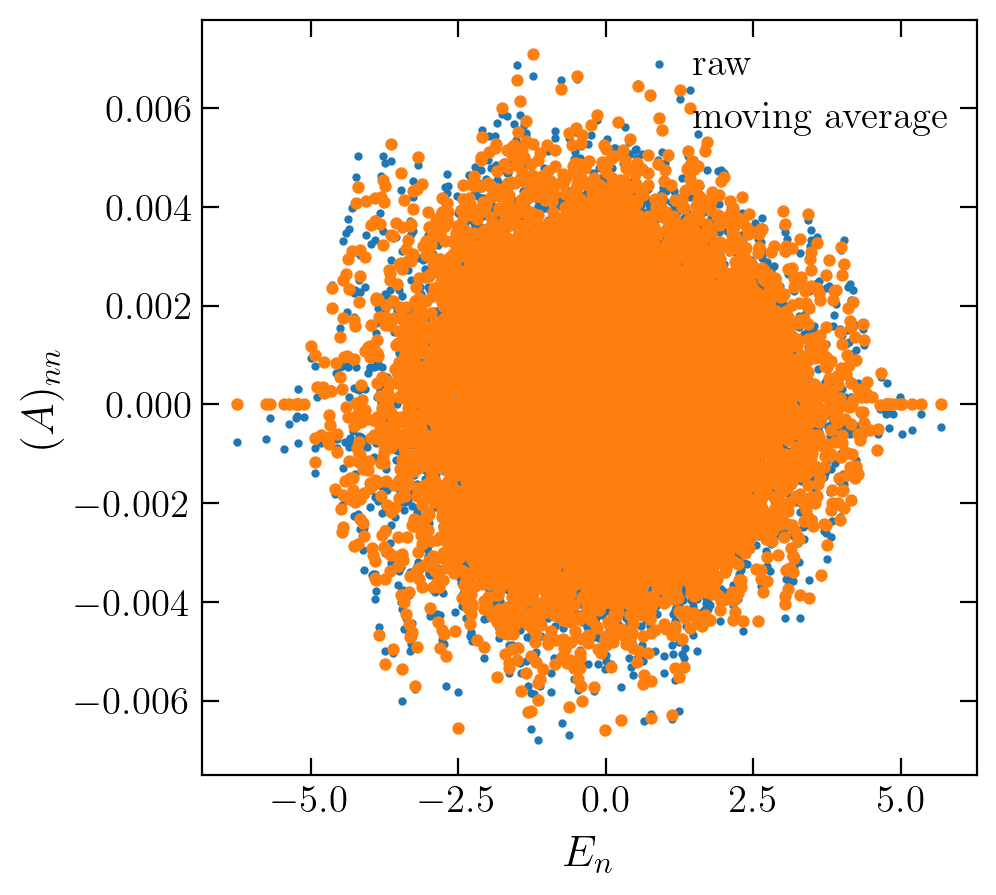

In [4]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharex=True)

L=20
J1=1.0
d1=0.2
e1=0.2

ks=1
ps=1
zxs=1
zzs=1

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

REMOVE_STRUCTURE = 1

sizes = np.arange(14, 25, 2) if BOUNDARY_COND == 'PBC' else np.arange(12, 20, 2)


# ks = L//2
name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
data_type = 'float' if ks == 0 or ks == L / 2 else 'complex'

if exists(name):
    with h5py.File(name, "r") as file:
        energies = np.array(file.get('energies')[0])
        op = np.array(file.get('Sq0')[0])
        jE = np.array(file.get('jE')[0]).view('complex')
        # print(energies.shape, Sq0.shape)
        if ks != 0 and ks != L / 2:
            jE = np.real(jE)


        data = jE

        axis.scatter(energies, data, s=4, label='raw')

        data = tools.get_fluctuations(data, bucket_size=20, type='mean')
        axis.scatter(energies, data, s=12, label="moving average")

        # data = get_fluctuations(data, bucket_size=5, type='median')
        # axis.scatter(energies, data, s=4, label="moving average: median")
        
else:
    print(name)



fig_help.set_plot_elements(axis, ylabel=r"$(A)_{nn}$", xlabel=r"$E_n$", font_size=14, set_legend=True)
axis.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.01,1.01))



fig.subplots_adjust(wspace = 0.3, hspace=0.05)


No handles with labels found to put in legend.


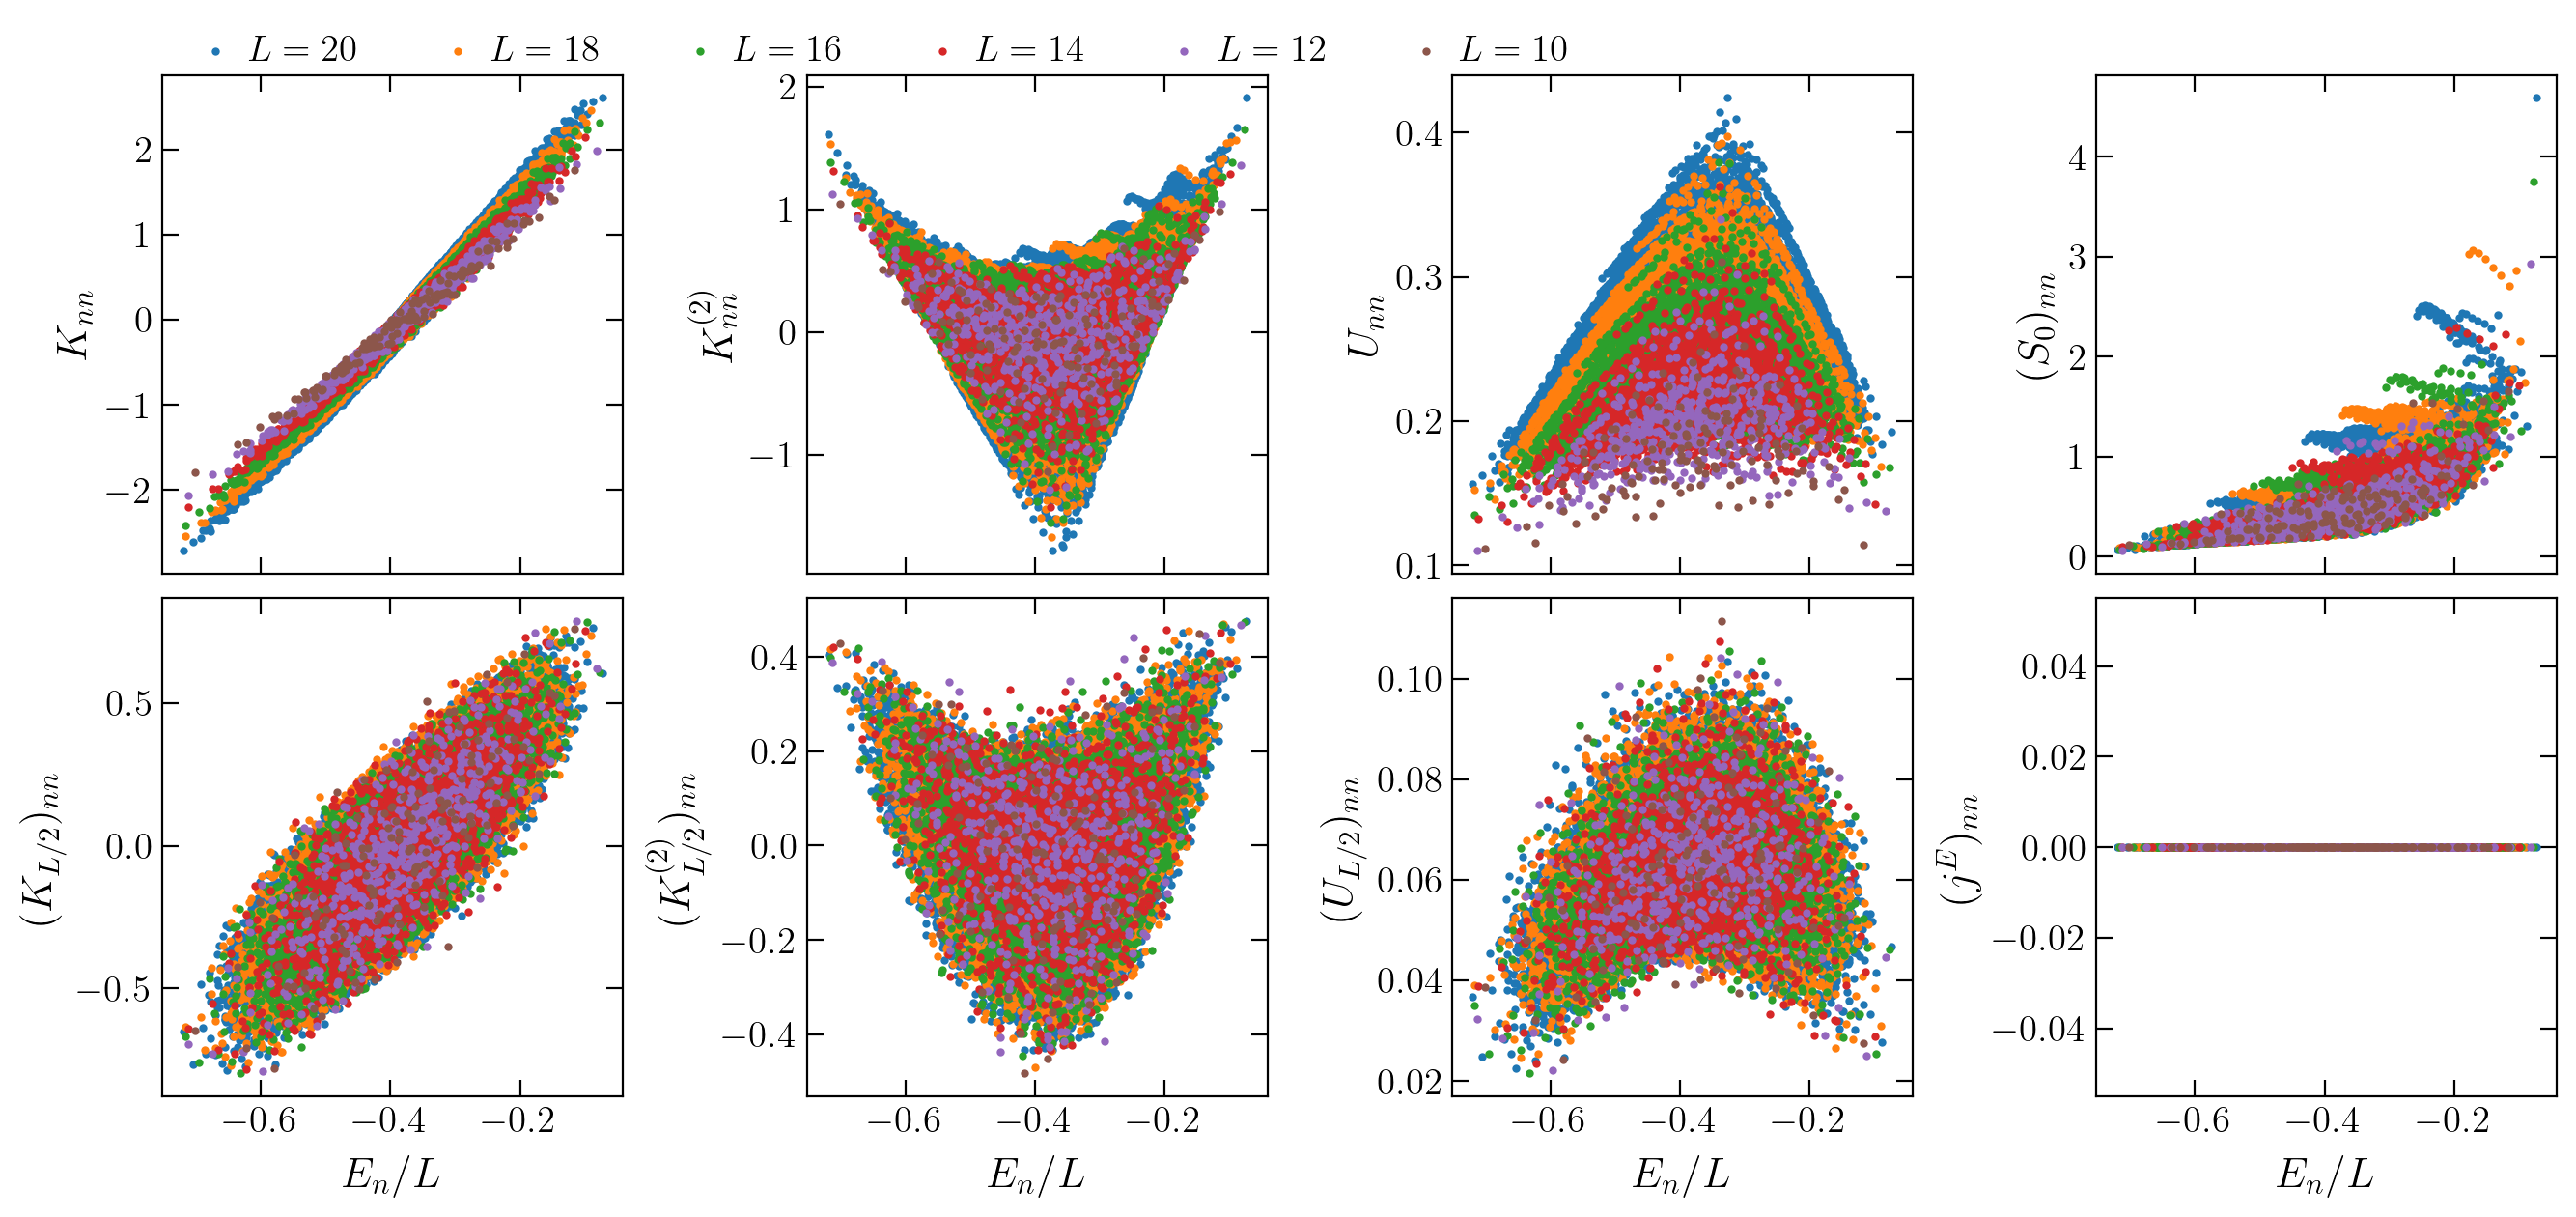

In [25]:
fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,7), dpi = 200, sharex=True)

axis_top = axes[0, :]
axis_bot = axes[1, :]
# axis_bot[-1].axis('off')


L=20
J1=1.0
d1=0.2
e1=0.2

ks=1
ps=1
zxs=1
zzs=1

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

REMOVE_STRUCTURE = 0
window = 50

sizes = np.arange(14, 25, 2) if BOUNDARY_COND == 'PBC' else np.arange(10, 21, 2)


for L in sizes[::-1]:
    # ks = L//2
    name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
    data_type = 'float' if ks == 0 or ks == L / 2 else 'complex'

    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('energies')[0]) - L/8 * (3+e1**2)
            
            Sq0 = np.array(file.get('Sq0')[0])
            jE = np.array(file.get('jE')[0]).view('complex')
            if any(np.abs(np.imag(jE)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
            else:                                   jE = np.real(jE)
            

            Kin = np.array(file.get('Kin')[0])
            Kin2 = np.array(file.get('Kin2')[0])
            Int = np.array(file.get('Int')[0])
            
            Kin_loc = np.array(file.get('Kin_loc')[0])
            Kin2_loc = np.array(file.get('Kin2_loc')[0])
            Int_loc = np.array(file.get('Int_loc')[0])

            if REMOVE_STRUCTURE:
                Sq0      = np.abs(get_fluctuations(Sq0,         bucket_size=window, type='mean'))
                jE       = np.abs(get_fluctuations(jE,          bucket_size=window, type='mean'))
                Kin      = np.abs(get_fluctuations(Kin,         bucket_size=window, type='mean'))
                Kin_loc  = np.abs(get_fluctuations(Kin_loc,     bucket_size=window, type='mean'))
                Kin2     = np.abs(get_fluctuations(Kin2,        bucket_size=window, type='mean'))
                Kin2_loc = np.abs(get_fluctuations(Kin2_loc,    bucket_size=window, type='mean'))
                Int      = np.abs(get_fluctuations(Int,         bucket_size=window, type='mean'))
                Int_loc  = np.abs(get_fluctuations(Int_loc,     bucket_size=window, type='mean'))
                
            axis_top[0].scatter(energies / L, Kin, s=4, label=r"$L=%d$"%L)
            axis_top[1].scatter(energies / L, Kin2, s=4)
            axis_top[2].scatter(energies / L, Int, s=4)
            axis_top[3].scatter(energies / L, Sq0, s=4)
            
            axis_bot[0].scatter(energies / L, Kin_loc, s=4)
            axis_bot[1].scatter(energies / L, Kin2_loc, s=4)
            axis_bot[2].scatter(energies / L, Int_loc, s=4)
            axis_bot[3].scatter(energies / L, jE, s=4)
            # if L >= sizes[-3]:
            #     hist, edges = np.histogram(energies / L, bins=int(L**2/10), normed=True)
            #     axis_bot[3].stairs(hist, edges, label=r"$L=%d$"%L)
            #     x_min = min(edges)
            #     x_max = max(edges)
    else:
        print(name)

# aa = np.linspace(x_min, x_max, 1000)
# axis_bot[3].plot(aa, 1 / np.sqrt(2*np.pi) * np.exp(-aa**2 / 2), ls='--', c='k')

def make_title(title):
    return r"$|%s-\overline{%s}|$"%(title, title) if REMOVE_STRUCTURE else r"$%s$"%title

scale = 'log' if REMOVE_STRUCTURE else 'linear'
fig_help.set_plot_elements(axis_top[0], ylabel=make_title("K_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_top[1], ylabel=make_title("K^{(2)}_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_top[2], ylabel=make_title("U_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

fig_help.set_plot_elements(axis_top[3], ylabel=make_title("(S_0)_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

fig_help.set_plot_elements(axis_bot[0], ylabel=make_title("(K_{L/2})_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[1], ylabel=make_title("(K^{(2)}_{L/2})_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[2], ylabel=make_title("(U_{L/2})_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[3], ylabel=make_title("(j^E)_{nn}"), xlabel=r"$E_n/L$", font_size=14, set_legend=False, yscale=scale)

axis_top[0].legend(frameon=0, fontsize=14, loc='upper left', ncol=8, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01, 1.15))
axis_bot[3].legend(frameon=0, fontsize=14, loc='upper left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01, 1.02))

fig.subplots_adjust(wspace = 0.4, hspace=0.05)

$K$ [-0.01590395  0.00218411] [14 16 18 20]
$K^{(2)}$ [-0.08970337  0.06555066] [14 16 18 20]
$U$ [-0.36300009  0.00085107] [14 16 18 20]
$S_0$ [-1.07972895  0.15576262] [14 16 18 20]
$K_{L/2}$ [-1.66432902  0.82590867] [14 16 18 20]
$K^{(2)}_{L/2}$ [-1.68403219  0.63258643] [14 16 18 20]
$U_{L/2}$ [-2.04425115  0.01095969] [14 16 18 20]
--------------- Repeat
$K$ [-0.01590395  0.00218411] [14 16 18 20]
$K^{(2)}$ [-0.08970337  0.06555066] [14 16 18 20]
$U$ [-0.36300009  0.00085107] [14 16 18 20]
$S_0$ [-1.07972895  0.15576262] [14 16 18 20]
$K_{L/2}$ [-1.66432902  0.82590867] [14 16 18 20]
$K^{(2)}_{L/2}$ [-1.68403219  0.63258643] [14 16 18 20]
$U_{L/2}$ [-2.04425115  0.01095969] [14 16 18 20]


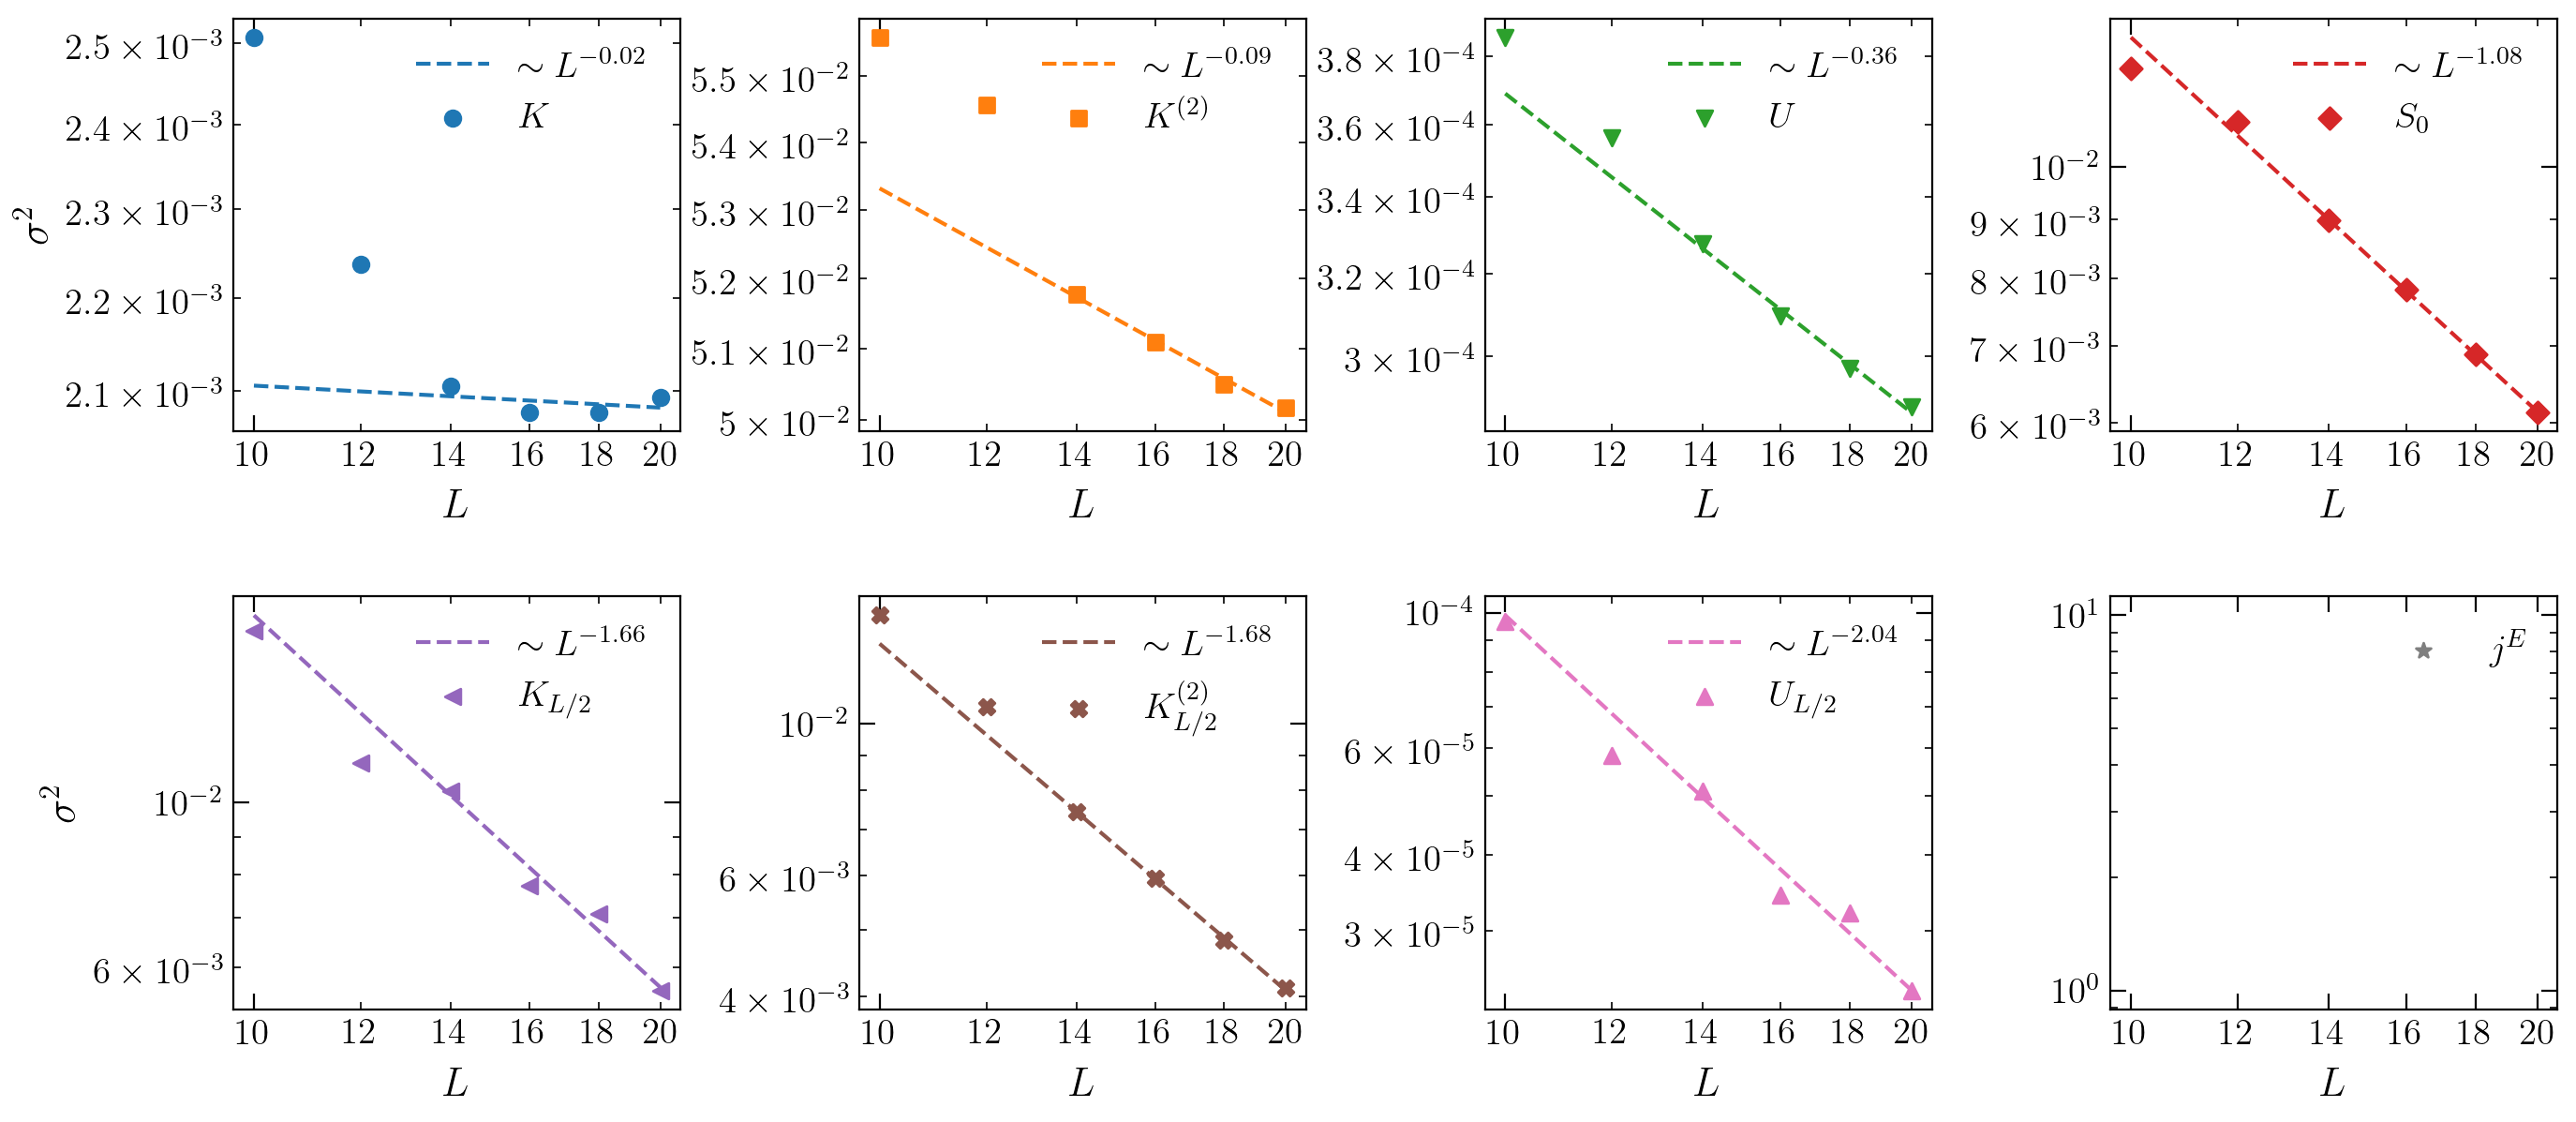

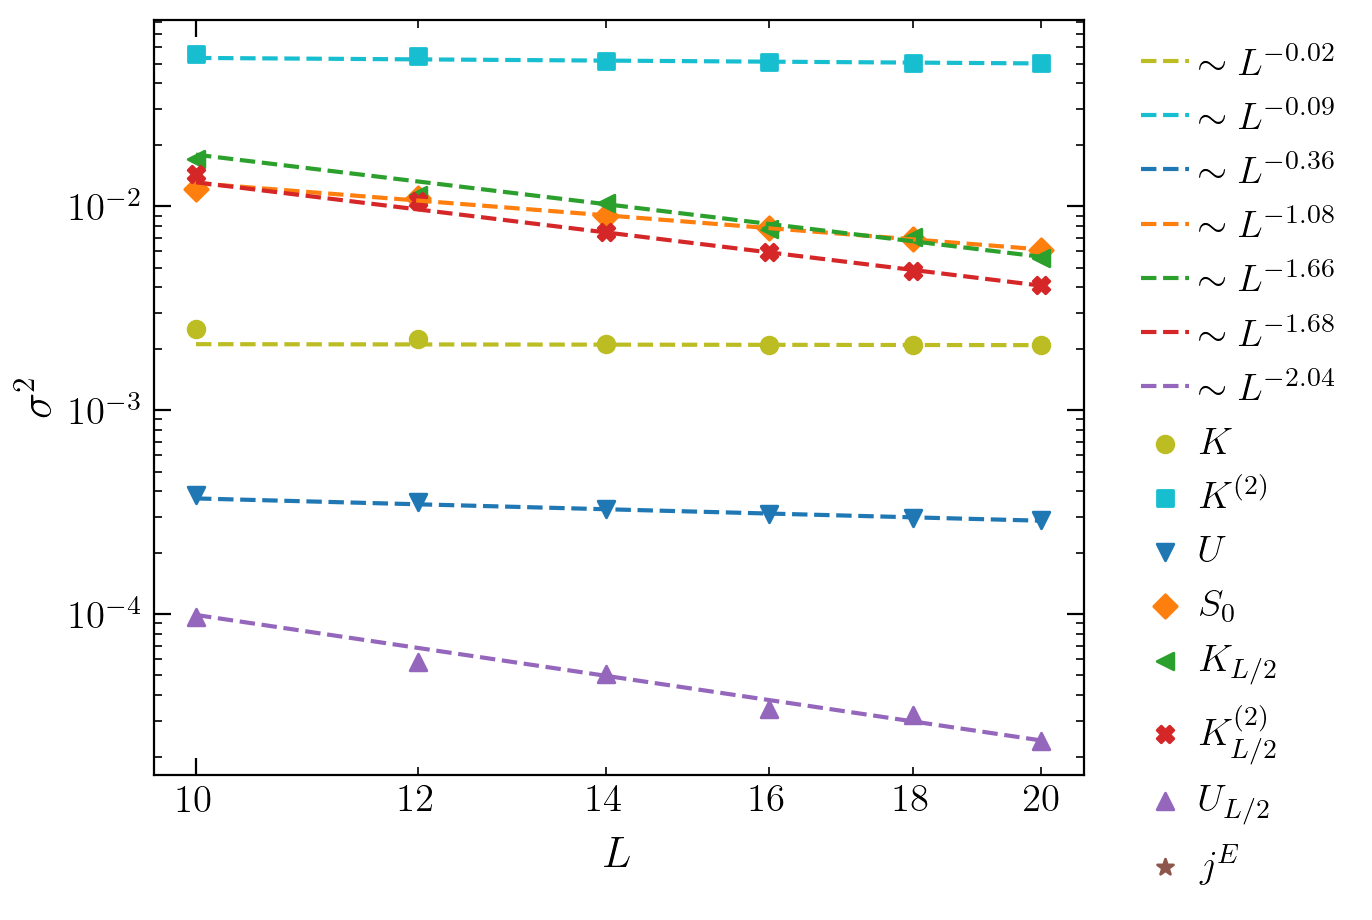

In [12]:
fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,7), dpi = 200)

axis_top = axes[0, :]
axis_bot = axes[1, :]
# axis_bot[-1].axis('off')

fig2, axis_full = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)

L=22
J1=1.0
d1=0.2
e1=0.2

REAL_SECTORS = 0

sizes = (np.arange(14, 25, 2) if REAL_SECTORS else np.arange(14, 24, 2)) if BOUNDARY_COND == 'PBC' else np.arange(10, 21, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)


folder_base = f'./matrix_elements/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

filenamee = folder + (f'variance_eta={e1},delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'variance_eta={e1},delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    for ii_L, L in enumerate(sizes):
        real_sec, imag_sec = get_sectors(L)
        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec


        Sq0_matelem = []
        Kin_matelem = []
        Kin_loc_matelem = []
        dim_tot = 0
        for [ks, ps, zxs, zzs] in real_sec if REAL_SECTORS else sects:
            factor = 1.0 if ks == 0 or (ks == L // 2 and L%2 == 0) else 2.0

            if ps + zxs + zzs == 3:
                print(L, ks, factor)
        # for [ks, ps, zxs, zzs] in [[0,1,1,1]]:
            name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    dim = energies.size
                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    bucket_size = 50
                    jE_tmp = np.array(file.get('jE')[0]).view('complex')
                    if any(np.abs(np.imag(jE_tmp)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
                    else:                                       jE_tmp = np.real(jE_tmp)

                    Sq0_tmp         = get_fluctuations(np.array(file.get('Sq0')[0]),        bucket_size=bucket_size, type='mean')
                    jE_tmp          = get_fluctuations(jE_tmp,                              bucket_size=bucket_size, type='mean')
                    Kin_tmp         = get_fluctuations(np.array(file.get('Kin')[0]),        bucket_size=bucket_size, type='mean')
                    Kin2_tmp        = get_fluctuations(np.array(file.get('Kin2')[0]),       bucket_size=bucket_size, type='mean')
                    Int_tmp         = get_fluctuations(np.array(file.get('Int')[0]),        bucket_size=bucket_size, type='mean')
                    Kin_loc_tmp     = get_fluctuations(np.array(file.get('Kin_loc')[0]),    bucket_size=bucket_size, type='mean')
                    Kin2_loc_tmp    = get_fluctuations(np.array(file.get('Kin2_loc')[0]),   bucket_size=bucket_size, type='mean')
                    Int_loc_tmp     = get_fluctuations(np.array(file.get('Int_loc')[0]),    bucket_size=bucket_size, type='mean')
                

                    num = 0.5 * dim

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    if num < dim and my_min > 0 and my_max < dim:
                        jE_tmp = (jE_tmp)[my_min : my_max]
                        Sq0_tmp = (Sq0_tmp)[my_min : my_max]
                        Kin_tmp = (Kin_tmp)[my_min : my_max]
                        Kin2_tmp = (Kin2_tmp)[my_min : my_max]
                        Int_tmp = (Int_tmp)[my_min : my_max]
                        Kin_loc_tmp = (Kin_loc_tmp)[my_min : my_max]
                        Kin2_loc_tmp = (Kin2_loc_tmp)[my_min : my_max]
                        Int_loc_tmp = (Int_loc_tmp)[my_min : my_max]

                    # Sq0_matelem     = [*Sq0_matelem,        *Sq0_tmp]
                    # Kin_matelem     = [*Kin_matelem,        *Kin_tmp]
                    # Kin_loc_matelem = [*Kin_loc_matelem,    *Kin_loc_tmp]

                    jE[ii_L] += np.sum(np.abs(jE_tmp)**2) * factor
                    Sq0[ii_L] += np.sum(np.abs(Sq0_tmp)**2) * factor
                    Kin[ii_L] += np.sum(np.abs(Kin_tmp)**2) * factor
                    Kin2[ii_L] += np.sum(np.abs(Kin2_tmp)**2) * factor
                    Int[ii_L] += np.sum(np.abs(Int_tmp)**2) * factor
                    Kin_loc[ii_L] += np.sum(np.abs(Kin_loc_tmp)**2) * factor
                    Kin2_loc[ii_L] += np.sum(np.abs(Kin2_loc_tmp)**2) * factor
                    Int_loc[ii_L] += np.sum(np.abs(Int_loc_tmp)**2) * factor

            else:
                print(name)

        # Sq0[ii_L] = np.var((Sq0_matelem))
        # Kin[ii_L] = np.var((Kin_matelem))
        # Kin_loc[ii_L] = np.var((Kin_loc_matelem))
        Sq0[ii_L]       /= dim_tot
        jE[ii_L]       /= dim_tot
        Kin[ii_L]       /= dim_tot
        Kin2[ii_L]       /= dim_tot
        Int[ii_L]       /= dim_tot
        Kin_loc[ii_L]   /= dim_tot
        Kin2_loc[ii_L]   /= dim_tot
        Int_loc[ii_L]   /= dim_tot

    data = {'sizes': sizes, 'Kin': Kin, 'Kin2': Kin2, 'Int': Int, 'Kin_loc': Kin_loc, 'Kin2_loc': Kin2_loc, 'Int_loc': Int_loc, 'Sq0': Sq0, 'jE': jE}
    df = pd.DataFrame(data=data)
    df.to_csv(filenamee)


# ----------------- RESCALE DATA


# -----------------

def plot_data(axis, x, y, legend = False, label = ""):
    sc = axis.scatter(x, rescale(sizes, y), marker=next(markers), color = next(colors_ls_cyc), label=label)
    if not any(np.isnan(y)) and not (all(np.abs(y) < 1e-14)):
        pars, pconv = fit(power_law,
                        xdata = x[-4:],
                        ydata = y[-4:])
        if np.abs(pars[0]) > 2.5:
            print(label, "power-law fit", pars)
            pars, pconv = fit(exp_fit,
                        xdata = x[-4:],
                        ydata = y[-4:])
            print(label, "exp fit", pars, x[-4:])
            xval = np.linspace(min(x), max(x), 100)
            axis.plot(xval, exp_fit(xval, *pars), ls=':', color=sc.get_facecolors()[0].tolist(), label=r"$\sim e^{-\frac{L}{%.2f}}$"%pars[0])
        else:
            print(label, pars, x[-4:])
            xval = np.linspace(min(x), max(x), 100)
            axis.plot(xval, power_law(xval, *pars), ls='--', color=sc.get_facecolors()[0].tolist(), label=r"$\sim L^{%.2f}$"%pars[0])
    

def rescale(x, y):
    return y

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)

plot_data(axis_top[0], sizes, rescale(sizes, Kin), label=r"$K$")
plot_data(axis_top[1], sizes, rescale(sizes, Kin2), label=r"$K^{(2)}$")
plot_data(axis_top[2], sizes, rescale(sizes, Int), label=r"$U$")
plot_data(axis_top[3], sizes, rescale(sizes, Sq0), label=r"$S_0$")
plot_data(axis_bot[0], sizes, rescale(sizes, Kin_loc), label=r"$K_{L/2}$")
plot_data(axis_bot[1], sizes, rescale(sizes, Kin2_loc), label=r"$K^{(2)}_{L/2}$")
plot_data(axis_bot[2], sizes, rescale(sizes, Int_loc), label=r"$U_{L/2}$")
plot_data(axis_bot[3], sizes, rescale(sizes, jE), label=r"$j^E$")

print("--------------- Repeat")
colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis_full, sizes, rescale(sizes, Kin)     , label=r"$K$")
plot_data(axis_full, sizes, rescale(sizes, Kin2)    , label=r"$K^{(2)}$")
plot_data(axis_full, sizes, rescale(sizes, Int)     , label=r"$U$")
plot_data(axis_full, sizes, rescale(sizes, Sq0)     , label=r"$S_0$")
plot_data(axis_full, sizes, rescale(sizes, Kin_loc) , label=r"$K_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Kin2_loc), label=r"$K^{(2)}_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Int_loc) , label=r"$U_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, jE)      , label=r"$j^E$")

def make_title(title):
    return r"$\left\langle%s-\overline{%s}\right\rangle$"%(title, title)

yscale = 'log'
xscale = 'log'
fig_help.set_plot_elements(axis_top[0], ylabel=r"$\sigma^2$", xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[1], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[2], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[3], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[0], ylabel=r"$\sigma^2$", xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[1], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[2], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[3], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)


fig_help.set_plot_elements(axis_full, ylabel=r"$\sigma^2$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log')
axis_full.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.31,1.01))


for ax in [axis_full, *axis_bot, *axis_top]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# for ax in [*axis_top]:
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""%x))
    # ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""%x))
axis_bot[3].set_xticks(sizes)

fig.subplots_adjust(wspace = 0.4, hspace=0.4)

$K$ [-0.04290428  0.04176024] [14 16 18 20]
$K^{(2)}$ [-0.04950974  0.20822149] [14 16 18 20]
$U$ [-0.1697241   0.02247933] [14 16 18 20]
$S_0$ [-0.50264887  0.27026225] [14 16 18 20]
$K_{L/2}$ [-0.8437436   0.76162999] [14 16 18 20]
$K^{(2)}_{L/2}$ [-0.84385721  0.64238828] [14 16 18 20]
$U_{L/2}$ [-0.99574356  0.07797327] [14 16 18 20]
--------------- Repeat
$K$ [-0.04290428  0.04176024] [14 16 18 20]
$K^{(2)}$ [-0.04950974  0.20822149] [14 16 18 20]
$U$ [-0.1697241   0.02247933] [14 16 18 20]
$S_0$ [-0.50264887  0.27026225] [14 16 18 20]
$K_{L/2}$ [-0.8437436   0.76162999] [14 16 18 20]
$K^{(2)}_{L/2}$ [-0.84385721  0.64238828] [14 16 18 20]
$U_{L/2}$ [-0.99574356  0.07797327] [14 16 18 20]


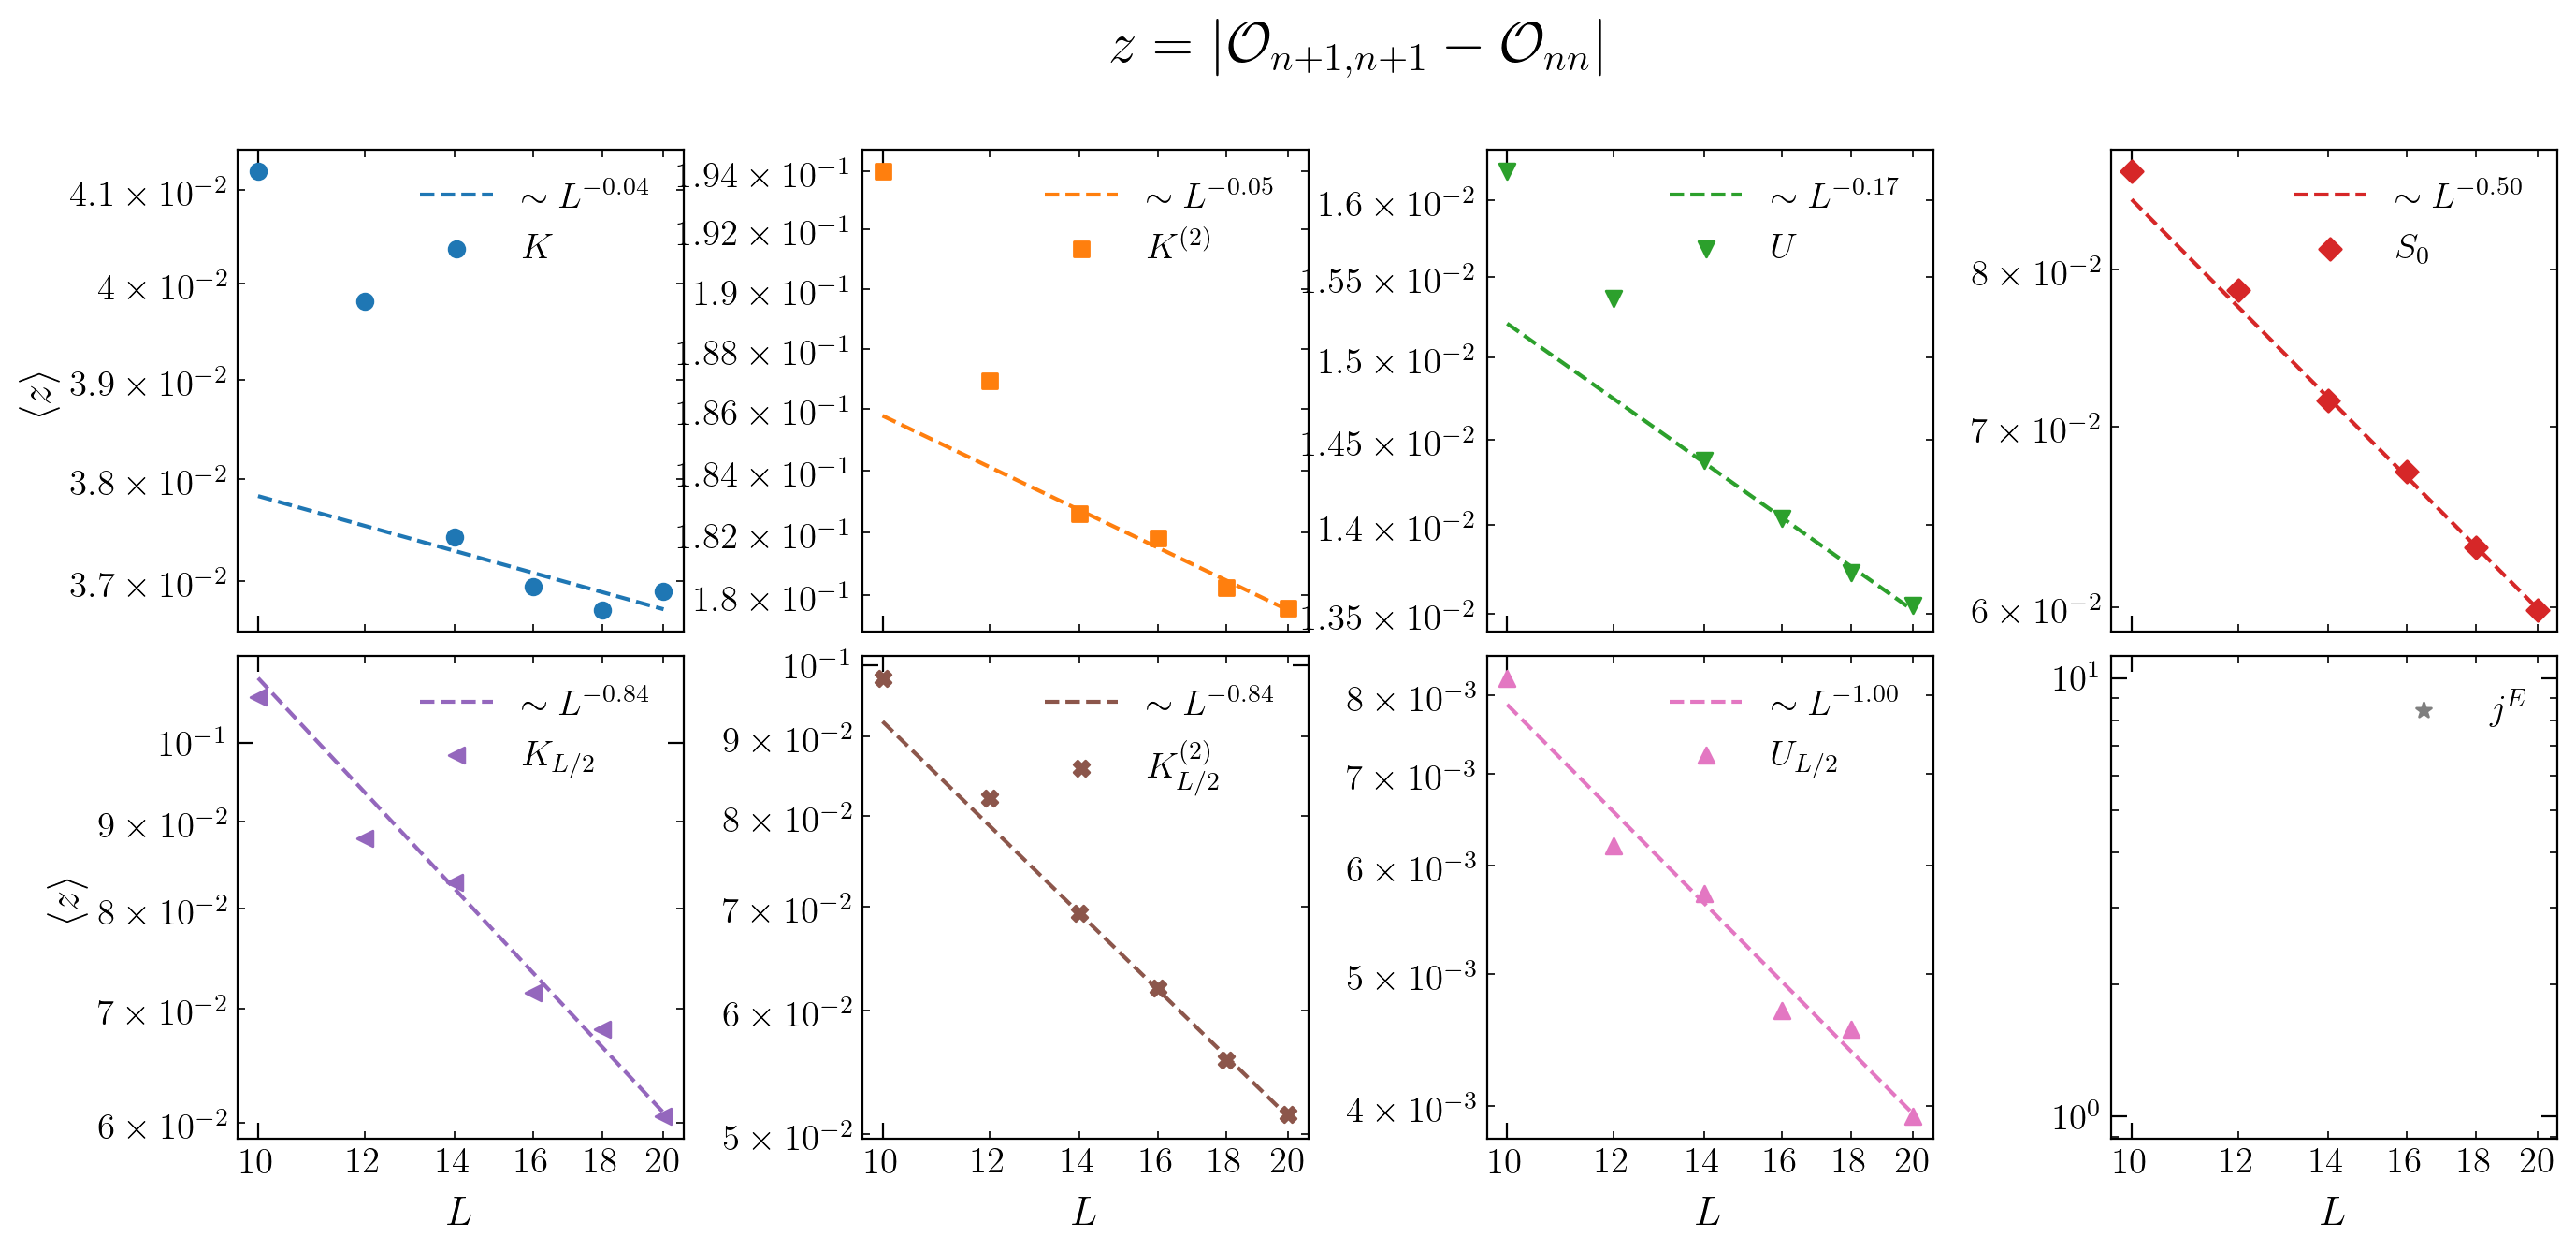

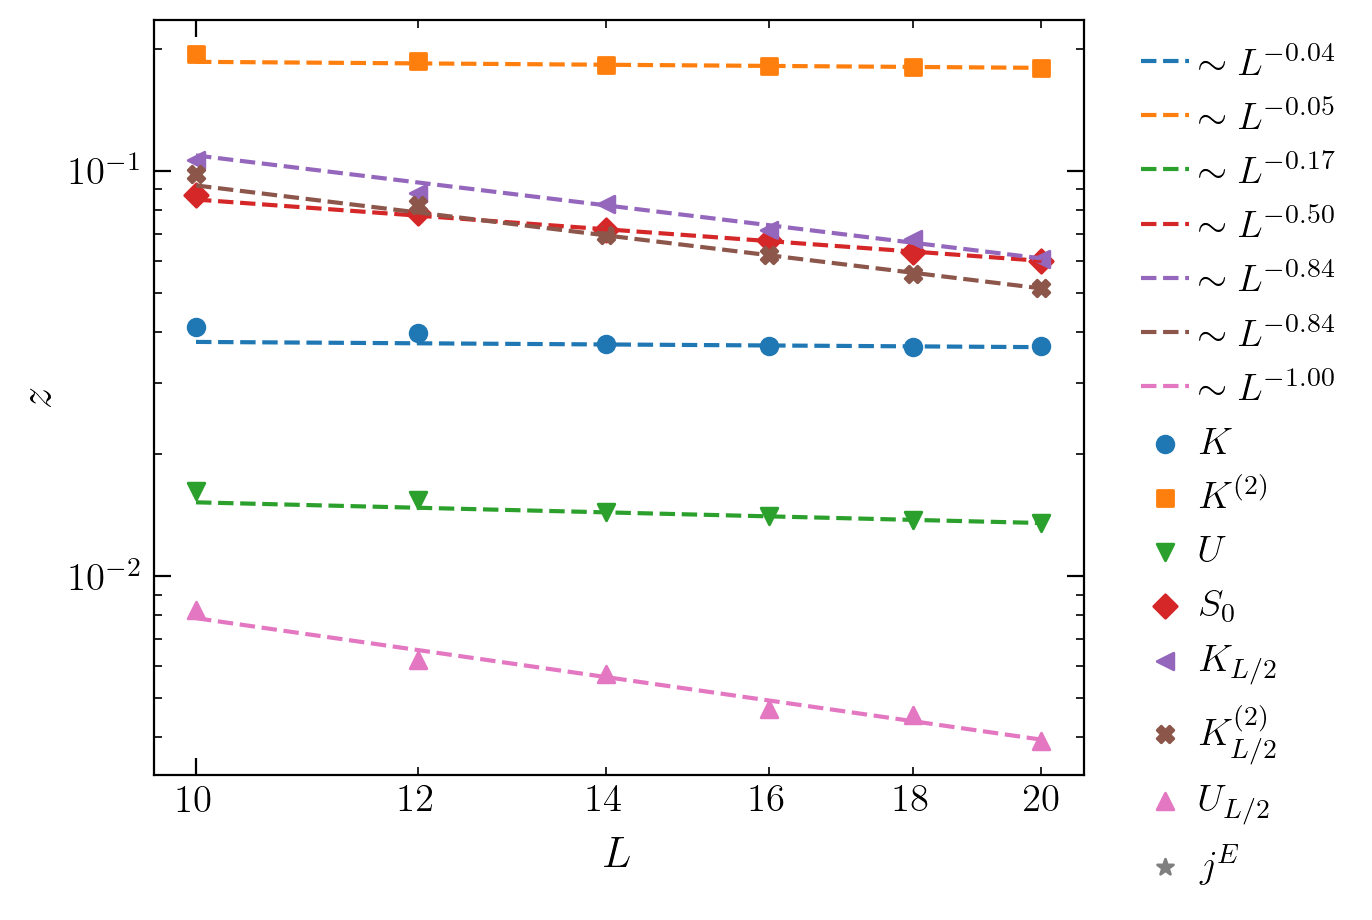

In [13]:
fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,7), dpi = 200, sharex=True)

axis_top = axes[0, :]
axis_bot = axes[1, :]
# axis_bot[-1].axis('off')

fig2, axis_full = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)

L=22
J1=1.0
d1=0.2
e1=0.2



folder_base = f'./matrix_elements/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

REAL_SECTORS = 0

sizes = (np.arange(14, 25, 2) if REAL_SECTORS else np.arange(14, 24, 2)) if BOUNDARY_COND == 'PBC' else np.arange(10, 21, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)

filenamee = folder + (f'Spacing_eta={e1},delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'Spacing_eta={e1},delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    for ii_L, L in enumerate(sizes):
        real_sec, imag_sec = get_sectors(L)
        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

        dim_tot = 0
        for [ks, ps, zxs, zzs] in real_sec if REAL_SECTORS else sects:
            factor = 1.0 if ks == 0 or (ks == L // 2 and L%2 == 0) else 2.0
        # for [ks, ps, zxs, zzs] in [[0, 1, 1, 1]]:
            name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    dim = energies.size

                    jE_tmp = np.array(file.get('jE')[0]).view('complex')
                    if any(np.abs(np.imag(jE_tmp)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
                    else:                                       jE_tmp = np.real(jE_tmp)

                    Sq0_tmp         = np.array(file.get('Sq0')[0])    
                    Kin_tmp         = np.array(file.get('Kin')[0]) 
                    Kin2_tmp        = np.array(file.get('Kin2')[0])
                    Int_tmp         = np.array(file.get('Int')[0]) 
                    Kin_loc_tmp     = np.array(file.get('Kin_loc')[0])
                    Kin2_loc_tmp    = np.array(file.get('Kin2_loc')[0])
                    Int_loc_tmp     = np.array(file.get('Int_loc')[0])

                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    num = 0.5 * dim

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    if num < dim and my_min > 0 and my_max < dim:
                        jE_tmp = np.diff(jE_tmp)[my_min : my_max]
                        Sq0_tmp = np.diff(Sq0_tmp)[my_min : my_max]
                        Kin_tmp = np.diff(Kin_tmp)[my_min : my_max]
                        Kin2_tmp = np.diff(Kin2_tmp)[my_min : my_max]
                        Int_tmp = np.diff(Int_tmp)[my_min : my_max]
                        Kin_loc_tmp = np.diff(Kin_loc_tmp)[my_min : my_max]
                        Kin2_loc_tmp = np.diff(Kin2_loc_tmp)[my_min : my_max]
                        Int_loc_tmp = np.diff(Int_loc_tmp)[my_min : my_max]
                    
                    jE[ii_L]        += np.sum(np.abs(jE_tmp)) * factor
                    Sq0[ii_L]       += np.sum(np.abs(Sq0_tmp)) * factor
                    Kin[ii_L]       += np.sum(np.abs(Kin_tmp)) * factor
                    Kin2[ii_L]      += np.sum(np.abs(Kin2_tmp)) * factor
                    Int[ii_L]       += np.sum(np.abs(Int_tmp)) * factor
                    Kin_loc[ii_L]   += np.sum(np.abs(Kin_loc_tmp)) * factor
                    Kin2_loc[ii_L]  += np.sum(np.abs(Kin2_loc_tmp)) * factor
                    Int_loc[ii_L]   += np.sum(np.abs(Int_loc_tmp)) * factor

            else:
                print(name)
        if dim_tot != 2**L:
            print("Missing sector:", dim_tot, 2**L)
        Sq0[ii_L]       /= dim_tot
        jE[ii_L]        /= dim_tot
        Kin[ii_L]       /= dim_tot
        Kin2[ii_L]      /= dim_tot
        Int[ii_L]       /= dim_tot
        Kin_loc[ii_L]   /= dim_tot
        Kin2_loc[ii_L]  /= dim_tot
        Int_loc[ii_L]   /= dim_tot

        print(L)
    data = {'sizes': sizes, 'Kin': Kin, 'Kin2': Kin2, 'Int': Int, 'Kin_loc': Kin_loc, 'Kin2_loc': Kin2_loc, 'Int_loc': Int_loc, 'Sq0': Sq0, 'jE': jE}
    df = pd.DataFrame(data=data)
    df.to_csv(filenamee)

def plot_data(axis, x, y, label = ""):
    sc = axis.scatter(x, rescale(sizes, y), marker=next(markers), color = next(colors), label=label)
    # print(y)
    if not any(np.isnan(y)) and not (all(np.abs(y) < 1e-14)):
        pars, pconv = fit(power_law,
                        xdata = x[-4:],
                        ydata = y[-4:])
        print(label, pars, x[-4:])
        xval = np.linspace(min(x), max(x), 100)
        axis.plot(xval, power_law(xval, *pars), ls='--', color=sc.get_facecolors()[0].tolist(), label=r"$\sim L^{%.2f}$"%pars[0])
    

def rescale(x, y):
    return y

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)

plot_data(axis_top[0], sizes, rescale(sizes, Kin)       , label=r"$K$")
plot_data(axis_top[1], sizes, rescale(sizes, Kin2)      , label=r"$K^{(2)}$")
plot_data(axis_top[2], sizes, rescale(sizes, Int)       , label=r"$U$")
plot_data(axis_top[3], sizes, rescale(sizes, Sq0)       , label=r"$S_0$")
plot_data(axis_bot[0], sizes, rescale(sizes, Kin_loc)   , label=r"$K_{L/2}$")
plot_data(axis_bot[1], sizes, rescale(sizes, Kin2_loc)  , label=r"$K^{(2)}_{L/2}$")
plot_data(axis_bot[2], sizes, rescale(sizes, Int_loc)   , label=r"$U_{L/2}$")
plot_data(axis_bot[3], sizes, rescale(sizes, jE)        , label=r"$j^E$")

print("--------------- Repeat")
colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis_full, sizes, rescale(sizes, Kin)     , label=r"$K$")
plot_data(axis_full, sizes, rescale(sizes, Kin2)    , label=r"$K^{(2)}$")
plot_data(axis_full, sizes, rescale(sizes, Int)     , label=r"$U$")
plot_data(axis_full, sizes, rescale(sizes, Sq0)     , label=r"$S_0$")
plot_data(axis_full, sizes, rescale(sizes, Kin_loc) , label=r"$K_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Kin2_loc), label=r"$K^{(2)}_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Int_loc) , label=r"$U_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, jE)      , label=r"$j^E$")

def make_title(title):
    return r"$\left\langle%s-\overline{%s}\right\rangle$"%(title, title)

yscale = 'log'
xscale = 'log'
fig_help.set_plot_elements(axis_top[0], ylabel=r"$\langle z\rangle$", xlabel="",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[1], ylabel="",     xlabel="",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[2], ylabel="",     xlabel="",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[3], ylabel="",     xlabel="",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)

fig_help.set_plot_elements(axis_bot[0], ylabel=r"$\langle z\rangle$", xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[1], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[2], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[3], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)


fig_help.set_plot_elements(axis_full, ylabel=r"$z$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log')
axis_full.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.31,1.01))

for ax in [axis_full, *axis_top[1:], *axis_bot[1:]]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# axis_full.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# axis_full.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

fig.suptitle(r"$z=|\mathcal{O}_{n+1,n+1}-\mathcal{O}_{nn}|$", fontsize=22)
fig.subplots_adjust(wspace = 0.4, hspace=0.05)

# XXZ

In [66]:

def info_xxz_base(L, J1=0, J2=0, delta1=0, delta2=0, hz=0):
    """
    Main body of file names with model parameters as input
    """
    arr = [J1, J2, delta1, delta2, hz]
    names = ['J1', 'J2','d1', 'd2', 'hz']
    info = "_L=%d"%L
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info


def info_xxz_sym(L, J1=0, J2=0, delta1=0, delta2=0, hz=0, k=0, p=1, zx=1, Sz=0.0, BOUNDARY_COND = 'PBC'):
    """
    Main body of file names with model parameters as input for symmetric model with symmetry sectors as input
    """
    info = info_xxz_base(L, J1, J2, delta1, delta2, hz)
    if BOUNDARY_COND == 'PBC':                          info += ",k=%d"%k
    if BOUNDARY_COND == 'OBC' or (k==0 or k==L/2):      info += ",p=%d"%p
    if Sz == 0.0:                                       info += ",zx=%d"%zx
    info += ",Sz=%.1f"%Sz
    return info

No handles with labels found to put in legend.


22 176870 0.2503563206887218 0.003228305785124351
20 46508 0.2500000000000031 0.0031640625000000483
18 12283 0.25142676323650603 0.0030864197530864226
16 3299 0.25 0.0029907226562500017
14 890 0.2556495391995967 0.0028698979591836736
12 252 0.24999999999999933 0.00271267361111111


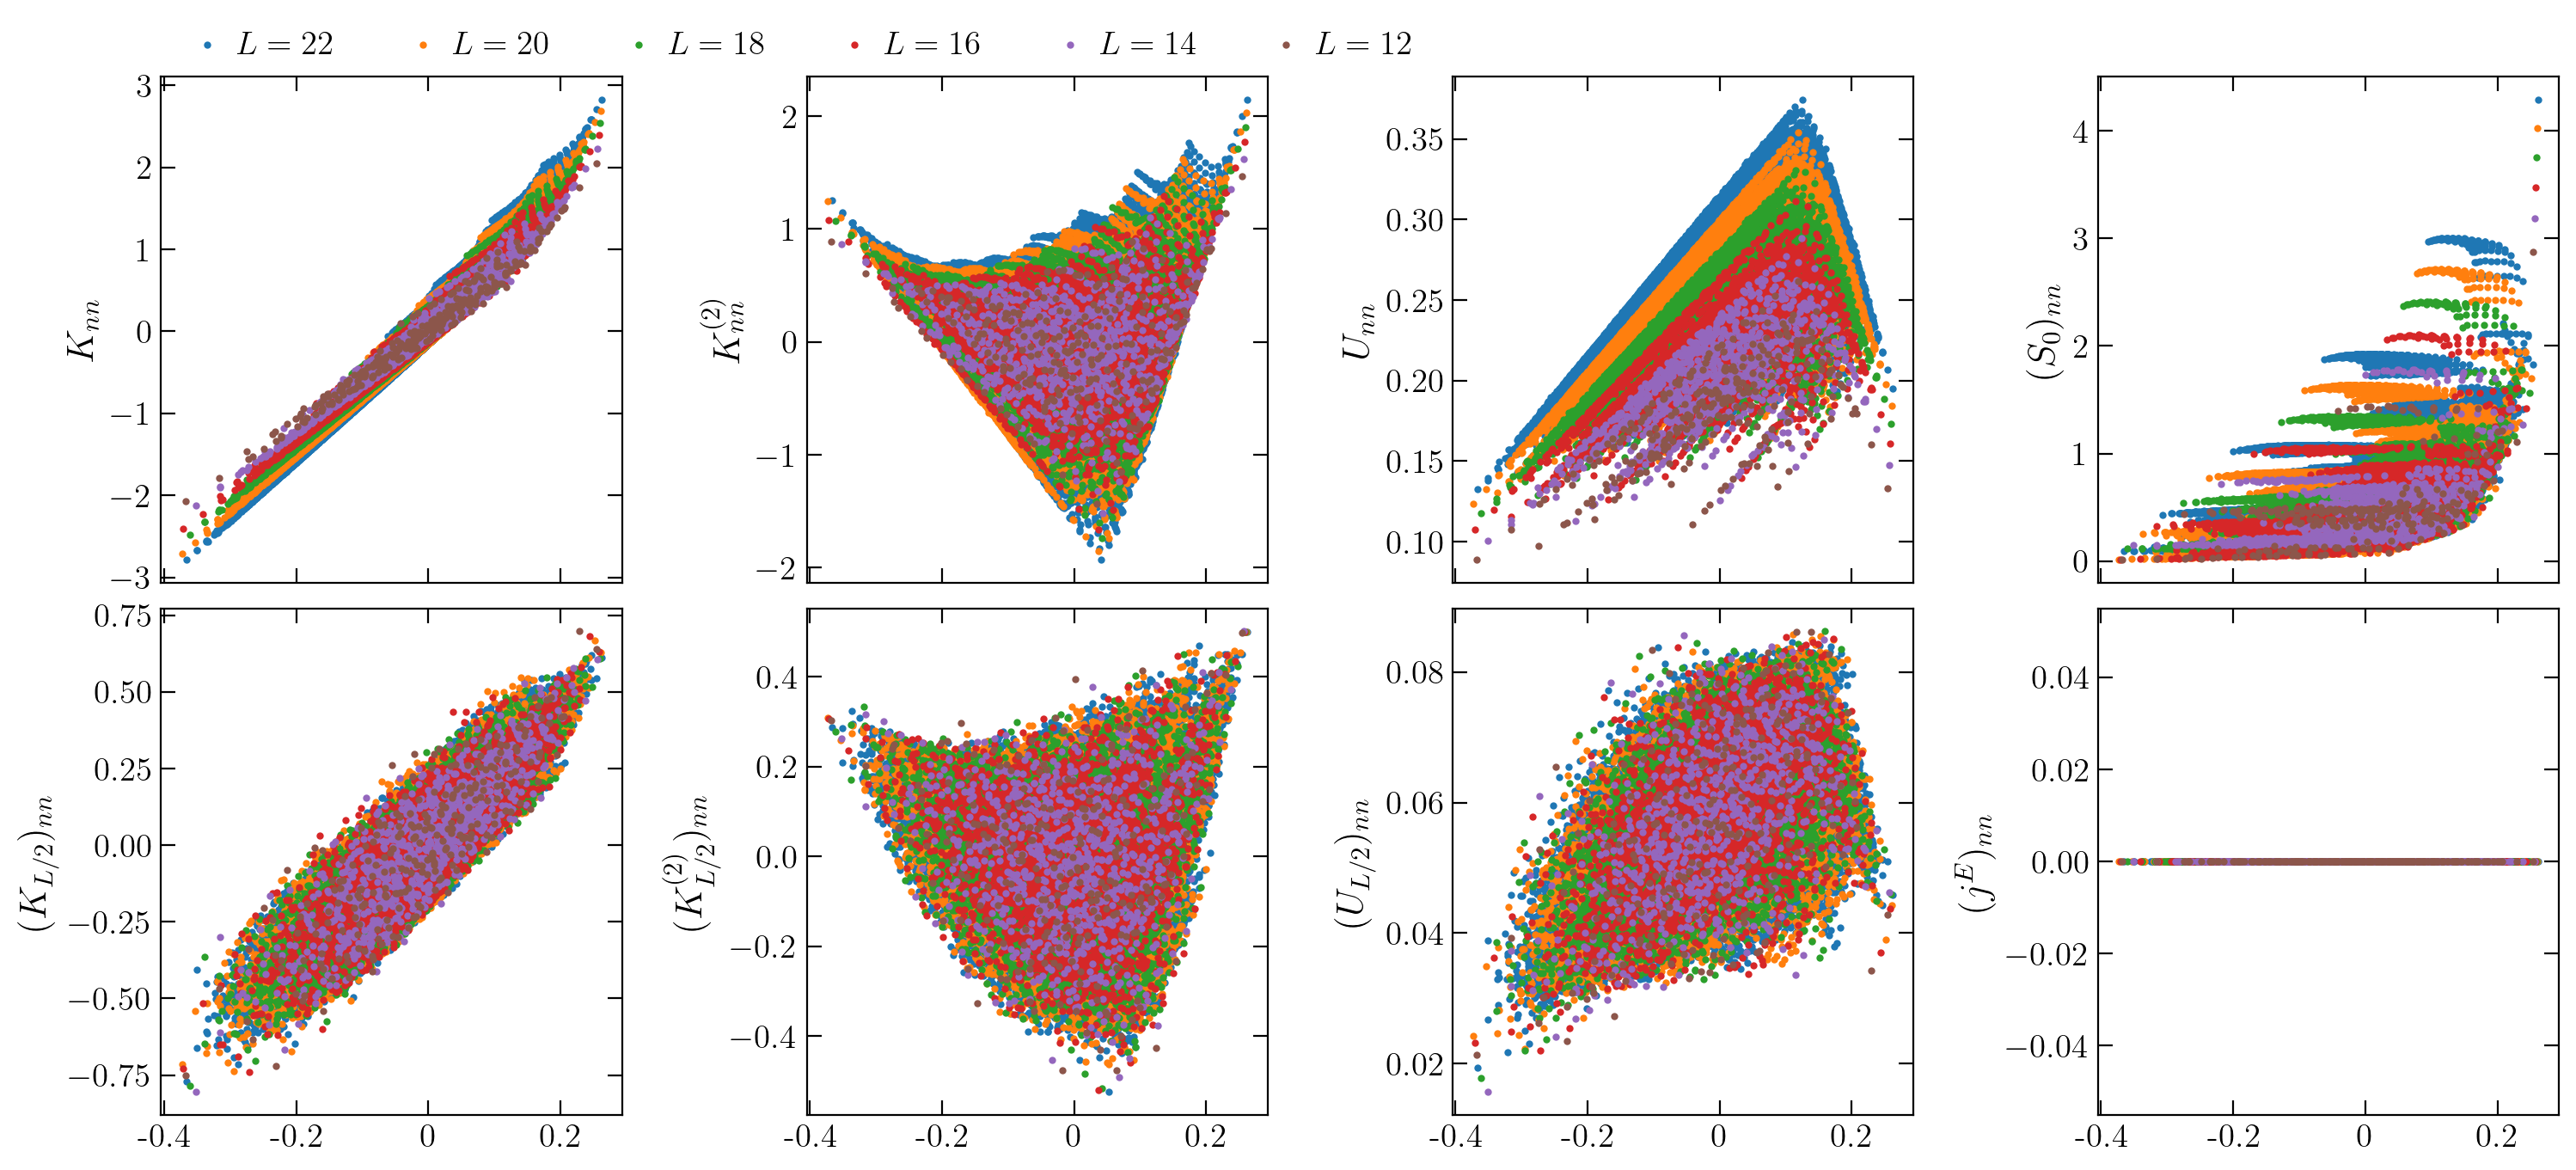

In [24]:

fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(18,8), dpi = 200, sharex=True)

axis_top = axes[0, :]
axis_bot = axes[1, :]

# axis_dis[-1].axis('off')


L=20
J1=1.0
d1=0.55
Sz=0

ks=1
ps=1
zxs=1
zzs=1

REMOVE_STRUCTURE = 0
window = 50

sizes = np.arange(14, 26, 2) if BOUNDARY_COND == 'PBC' else np.arange(12, 23, 2)


for L in sizes[::-1]:
    # ks = L//2
    name = f"../../XXZ/results/symmetries/" + BOUNDARY_COND + "/DiagonalMatrixElements/" + info_xxz_sym(L=L, J1=J1, delta1=d1, hz=0.0, k=ks, p=ps, zx=zxs, Sz=Sz, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
    #info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
    data_type = 'float' if ks == 0 or ks == L / 2 else 'complex'

    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('energies')[0])
            # print(L, energies.size)
            jE = np.array(file.get('jE')[0]).view('complex')
            if any(np.abs(np.imag(jE)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
            else:                                   jE = np.real(jE)

            Sq0 = np.array(file.get('Sq0')[0])
            
            Kin = np.array(file.get('Kin')[0])
            Kin2 = np.array(file.get('Kin2')[0])
            Int = np.array(file.get('Int')[0])
            
            Kin_loc = np.array(file.get('Kin_loc')[0])
            Kin2_loc = np.array(file.get('Kin2_loc')[0])
            Int_loc = np.array(file.get('Int_loc')[0])
            
            if REMOVE_STRUCTURE:
                Sq0      = np.abs(get_fluctuations(Sq0,         bucket_size=window, type='mean'))
                jE       = np.abs(get_fluctuations(jE,          bucket_size=window, type='mean'))
                Kin      = np.abs(get_fluctuations(Kin,         bucket_size=window, type='mean'))
                Kin_loc  = np.abs(get_fluctuations(Kin_loc,     bucket_size=window, type='mean'))
                Kin2     = np.abs(get_fluctuations(Kin2,        bucket_size=window, type='mean'))
                Kin2_loc = np.abs(get_fluctuations(Kin2_loc,    bucket_size=window, type='mean'))
                Int      = np.abs(get_fluctuations(Int,         bucket_size=window, type='mean'))
                Int_loc  = np.abs(get_fluctuations(Int_loc,     bucket_size=window, type='mean'))
                
            axis_top[0].scatter(energies / L, Kin, s=4, label=r"$L=%d$"%L)
            axis_top[1].scatter(energies / L, Kin2, s=4)
            axis_top[2].scatter(energies / L, Int, s=4)
            axis_top[3].scatter(energies / L, Sq0, s=4)
            
            axis_bot[0].scatter(energies / L, Kin_loc, s=4)
            axis_bot[1].scatter(energies / L, Kin2_loc, s=4)
            axis_bot[2].scatter(energies / L, Int_loc, s=4)
            axis_bot[3].scatter(energies / L, jE, s=4)
            # axis_bot[3].hist(energies / L, nbins=100, normed=True)
            # if L >= sizes[-3]:
            #     hist, edges = np.histogram(energies / L, bins=int(L**2/10), normed=True)
            #     axis_bot[3].stairs(hist, edges, label=r"$L=%d$"%L)
            #     x_min = min(edges)
            #     x_max = max(edges)
    else:
        print(name)

# aa = np.linspace(x_min, x_max, 1000)
# axis_bot[3].plot(aa, 1 / np.sqrt(2*np.pi) * np.exp(-aa**2 / 2), ls='--', c='k')

def make_title(title):
    return r"$|%s-\overline{%s}|$"%(title, title) if REMOVE_STRUCTURE else r"$%s$"%title

scale = 'log' if REMOVE_STRUCTURE else 'linear'
fig_help.set_plot_elements(axis_top[0], ylabel=make_title("K_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_top[1], ylabel=make_title("K^{(2)}_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_top[2], ylabel=make_title("U_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

fig_help.set_plot_elements(axis_top[3], ylabel=make_title("(S_0)_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

fig_help.set_plot_elements(axis_bot[0], ylabel=make_title("(K_{L/2})_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[1], ylabel=make_title("(K^{(2)}_{L/2})_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[2], ylabel=make_title("(U_{L/2})_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)
fig_help.set_plot_elements(axis_bot[3], ylabel=make_title("(j^E)_{nn}"), xlabel="", font_size=14, set_legend=False, yscale=scale)

axis_top[0].legend(frameon=0, fontsize=14, loc='upper left', ncol=8, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01, 1.15))
axis_bot[3].legend(frameon=0, fontsize=14, loc='upper left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01, 1.02))

if REMOVE_STRUCTURE:
    for ax in axes.flatten():
        ax.set_ylim(1e-7, None)
    
fig.subplots_adjust(wspace = 0.4, hspace=0.05)
axis_bot[3].xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
axis_bot[3].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


$K$ [-0.14171495  0.00696472] [16 18 20 22]
$K^{(2)}$ [0.01901893 0.07715549] [16 18 20 22]
$U$ [-0.14186512  0.00035991] [16 18 20 22]
$S_0$ [-1.0790505   0.68231444] [16 18 20 22]
$K_{L/2}$ [-1.27710029  0.17405058] [16 18 20 22]
$K^{(2)}_{L/2}$ [-1.35669791  0.39630067] [16 18 20 22]
$U_{L/2}$ [-1.60624392  0.00307389] [16 18 20 22]
--------------- Repeat
$K$ [-0.14171495  0.00696472] [16 18 20 22]
$K^{(2)}$ [0.01901893 0.07715549] [16 18 20 22]
$U$ [-0.14186512  0.00035991] [16 18 20 22]
$S_0$ [-1.0790505   0.68231444] [16 18 20 22]
$K_{L/2}$ [-1.27710029  0.17405058] [16 18 20 22]
$K^{(2)}_{L/2}$ [-1.35669791  0.39630067] [16 18 20 22]
$U_{L/2}$ [-1.60624392  0.00307389] [16 18 20 22]


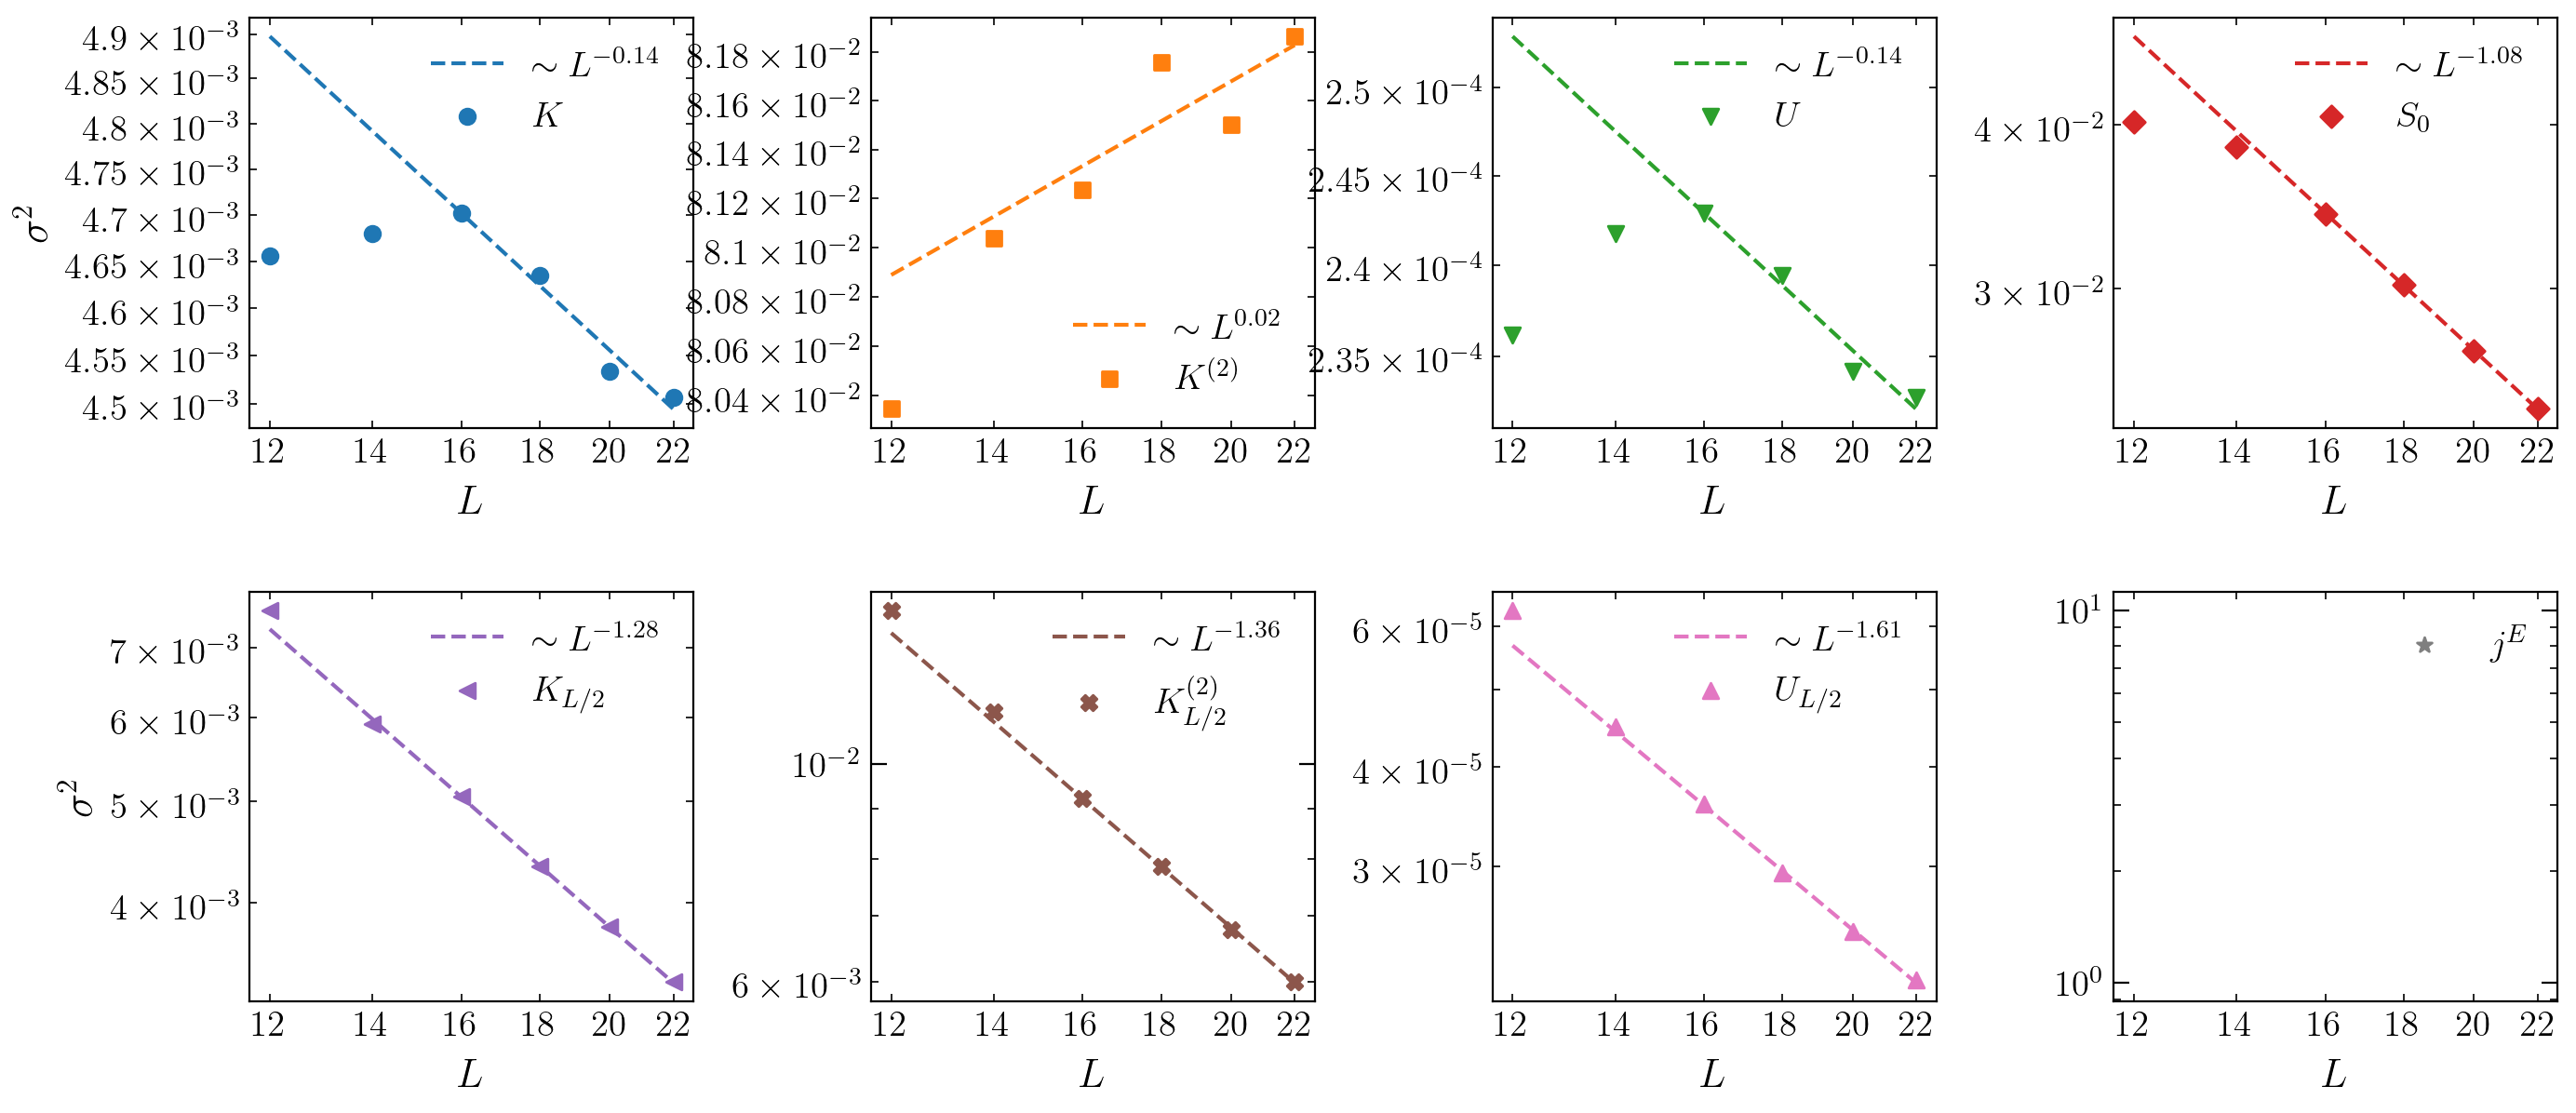

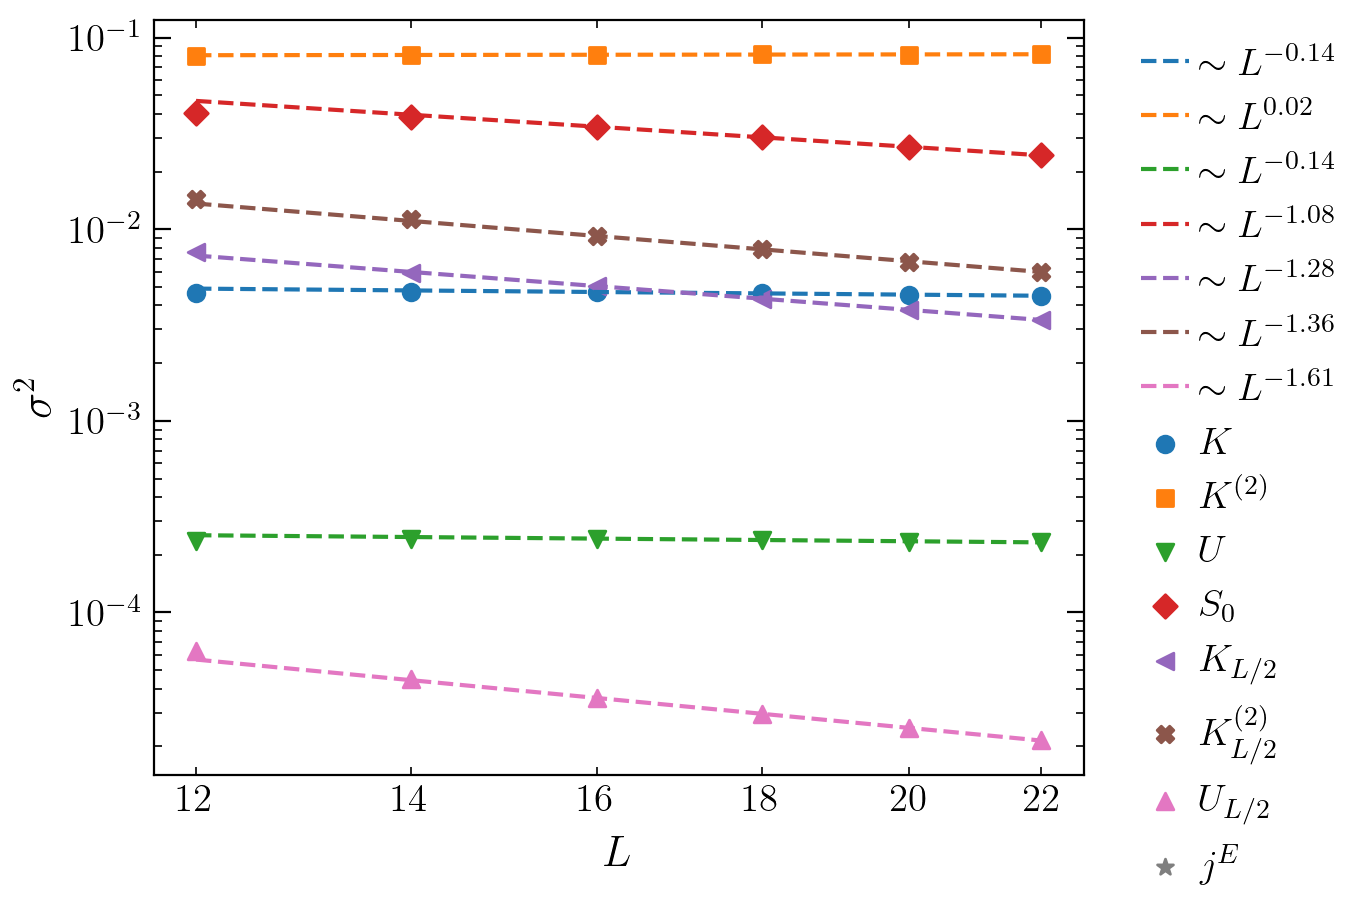

In [15]:
fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,7), dpi = 200)

axis_top = axes[0, :]
axis_bot = axes[1, :]
# axis_bot[-1].axis('off')

fig2, axis_full = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)

L=22
J1=1.0
d1=0.55

REAL_SECTORS = 0

sizes = (np.arange(14, 26, 2) if REAL_SECTORS else np.arange(14, 26, 2)) if BOUNDARY_COND == 'PBC' else np.arange(12, 23, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)


folder_base = f'./matrix_elements/XXZ/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

filenamee = folder + (f'variance_delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'variance_delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    for ii_L, L in enumerate(sizes):
        real_sec, imag_sec = get_sectors(L, hx=0.1)
        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec


        Sq0_matelem = []
        Kin_matelem = []
        Kin_loc_matelem = []
        dim_tot = 0
        for [ks, ps, zxs, zzs] in real_sec if REAL_SECTORS else sects:
        # for [ks, ps, zxs, zzs] in [[0,1,1,1]]:
            
            factor = 1.0 if ks == 0 or (ks == L // 2 and L%2 == 0) else 2.0

            name = f"../../XXZ/results/symmetries/" + BOUNDARY_COND + "/DiagonalMatrixElements/" + info_xxz_sym(L=L, J1=J1, delta1=d1, hz=0.0, k=ks, p=ps, zx=zxs, Sz=Sz, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    dim = energies.size
                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    bucket_size = 50
                    jE_tmp = np.array(file.get('jE')[0]).view('complex')
                    if any(np.abs(np.imag(jE_tmp)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
                    else:                                       jE_tmp = np.real(jE_tmp)

                    Sq0_tmp         = get_fluctuations(np.array(file.get('Sq0')[0]),        bucket_size=bucket_size, type='mean')
                    jE_tmp          = get_fluctuations(jE_tmp,                              bucket_size=bucket_size, type='mean')
                    Kin_tmp         = get_fluctuations(np.array(file.get('Kin')[0]),        bucket_size=bucket_size, type='mean')
                    Kin2_tmp        = get_fluctuations(np.array(file.get('Kin2')[0]),       bucket_size=bucket_size, type='mean')
                    Int_tmp         = get_fluctuations(np.array(file.get('Int')[0]),        bucket_size=bucket_size, type='mean')
                    Kin_loc_tmp     = get_fluctuations(np.array(file.get('Kin_loc')[0]),    bucket_size=bucket_size, type='mean')
                    Kin2_loc_tmp    = get_fluctuations(np.array(file.get('Kin2_loc')[0]),   bucket_size=bucket_size, type='mean')
                    Int_loc_tmp     = get_fluctuations(np.array(file.get('Int_loc')[0]),    bucket_size=bucket_size, type='mean')
                

                    num = 0.5 * dim

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    if num < dim and my_min > 0 and my_max < dim:
                        jE_tmp = (jE_tmp)[my_min : my_max]
                        Sq0_tmp = (Sq0_tmp)[my_min : my_max]
                        Kin_tmp = (Kin_tmp)[my_min : my_max]
                        Kin2_tmp = (Kin2_tmp)[my_min : my_max]
                        Int_tmp = (Int_tmp)[my_min : my_max]
                        Kin_loc_tmp = (Kin_loc_tmp)[my_min : my_max]
                        Kin2_loc_tmp = (Kin2_loc_tmp)[my_min : my_max]
                        Int_loc_tmp = (Int_loc_tmp)[my_min : my_max]

                    # Sq0_matelem     = [*Sq0_matelem,        *Sq0_tmp]
                    # Kin_matelem     = [*Kin_matelem,        *Kin_tmp]
                    # Kin_loc_matelem = [*Kin_loc_matelem,    *Kin_loc_tmp]

                    Sq0[ii_L]       += np.sum(np.abs(Sq0_tmp)**2) * factor
                    jE[ii_L]        += np.sum(np.abs(jE_tmp)**2) * factor
                    Kin[ii_L]       += np.sum(np.abs(Kin_tmp)**2) * factor
                    Kin2[ii_L]      += np.sum(np.abs(Kin2_tmp)**2) * factor
                    Int[ii_L]       += np.sum(np.abs(Int_tmp)**2) * factor
                    Kin_loc[ii_L]   += np.sum(np.abs(Kin_loc_tmp)**2) * factor
                    Kin2_loc[ii_L]  += np.sum(np.abs(Kin2_loc_tmp)**2) * factor
                    Int_loc[ii_L]   += np.sum(np.abs(Int_loc_tmp)**2) * factor

            else:
                print(name)

        # Sq0[ii_L] = np.var((Sq0_matelem))
        # Kin[ii_L] = np.var((Kin_matelem))
        # Kin_loc[ii_L] = np.var((Kin_loc_matelem))
        Sq0[ii_L]       /= dim_tot
        jE[ii_L]       /= dim_tot
        Kin[ii_L]       /= dim_tot
        Kin2[ii_L]       /= dim_tot
        Int[ii_L]       /= dim_tot
        Kin_loc[ii_L]   /= dim_tot
        Kin2_loc[ii_L]   /= dim_tot
        Int_loc[ii_L]   /= dim_tot

        print(L)
    data = {'sizes': sizes, 'Kin': Kin, 'Kin2': Kin2, 'Int': Int, 'Kin_loc': Kin_loc, 'Kin2_loc': Kin2_loc, 'Int_loc': Int_loc, 'Sq0': Sq0, 'jE': jE}
    df = pd.DataFrame(data=data)
    df.to_csv(filenamee)

def plot_data(axis, x, y, legend = False, label = ""):
    sc = axis.scatter(x, rescale(sizes, y), marker=next(markers), color = next(colors), label=label)
    if not any(np.isnan(y)) and not (all(np.abs(y) < 1e-14)):
        pars, pconv = fit(power_law,
                        xdata = x[-4:],
                        ydata = y[-4:])
        print(label, pars, x[-4:])
        xval = np.linspace(min(x), max(x), 100)
        axis.plot(xval, power_law(xval, *pars), ls='--', color=sc.get_facecolors()[0].tolist(), label=r"$\sim L^{%.2f}$"%pars[0])
    

def rescale(x, y):
    return y

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)

plot_data(axis_top[0], sizes, rescale(sizes, Kin)       , label=r"$K$")
plot_data(axis_top[1], sizes, rescale(sizes, Kin2)      , label=r"$K^{(2)}$")
plot_data(axis_top[2], sizes, rescale(sizes, Int)       , label=r"$U$")
plot_data(axis_top[3], sizes, rescale(sizes, Sq0)       , label=r"$S_0$")
plot_data(axis_bot[0], sizes, rescale(sizes, Kin_loc)   , label=r"$K_{L/2}$")
plot_data(axis_bot[1], sizes, rescale(sizes, Kin2_loc)  , label=r"$K^{(2)}_{L/2}$")
plot_data(axis_bot[2], sizes, rescale(sizes, Int_loc)   , label=r"$U_{L/2}$")
plot_data(axis_bot[3], sizes, rescale(sizes, jE)        , label=r"$j^E$")

print("--------------- Repeat")
colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis_full, sizes, rescale(sizes, Kin)     , label=r"$K$")
plot_data(axis_full, sizes, rescale(sizes, Kin2)    , label=r"$K^{(2)}$")
plot_data(axis_full, sizes, rescale(sizes, Int)     , label=r"$U$")
plot_data(axis_full, sizes, rescale(sizes, Sq0)     , label=r"$S_0$")
plot_data(axis_full, sizes, rescale(sizes, Kin_loc) , label=r"$K_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Kin2_loc), label=r"$K^{(2)}_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Int_loc) , label=r"$U_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, jE)      , label=r"$j^E$")

def make_title(title):
    return r"$\left\langle%s-\overline{%s}\right\rangle$"%(title, title)

yscale = 'log'
xscale = 'log'
fig_help.set_plot_elements(axis_top[0], ylabel=r"$\sigma^2$", xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[1], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[2], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[3], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[0], ylabel=r"$\sigma^2$", xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[1], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[2], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[2], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[3], ylabel="",            xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)


fig_help.set_plot_elements(axis_full, ylabel=r"$\sigma^2$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log')
axis_full.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.31,1.01))


for ax in [axis_full, *axis_top, *axis_bot]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    
fig.subplots_adjust(wspace = 0.4, hspace=0.4)

$K$ [-0.09342215  0.07548427] [18 20 22 24]
$K^{(2)}$ [-0.04057197  0.27195746] [18 20 22 24]
$U$ [-0.09257202  0.01711016] [18 20 22 24]
$S_0$ [-0.5627083   0.75506963] [18 20 22 24]
$K_{L/2}$ [-0.59064414  0.07485138] [18 20 22 24]
$K^{(2)}_{L/2}$ [-0.53958628  0.27114588] [18 20 22 24]
$U_{L/2}$ [-0.58974102  0.01696398] [18 20 22 24]
$j^E$ [-0.49157499  0.11795788] [18 20 22 24]
--------------- Repeat
$K$ [-0.09342215  0.07548427] [18 20 22 24]
$K^{(2)}$ [-0.04057197  0.27195746] [18 20 22 24]
$U$ [-0.09257202  0.01711016] [18 20 22 24]
$S_0$ [-0.5627083   0.75506963] [18 20 22 24]
$K_{L/2}$ [-0.59064414  0.07485138] [18 20 22 24]
$K^{(2)}_{L/2}$ [-0.53958628  0.27114588] [18 20 22 24]
$U_{L/2}$ [-0.58974102  0.01696398] [18 20 22 24]
$j^E$ [-0.49157499  0.11795788] [18 20 22 24]


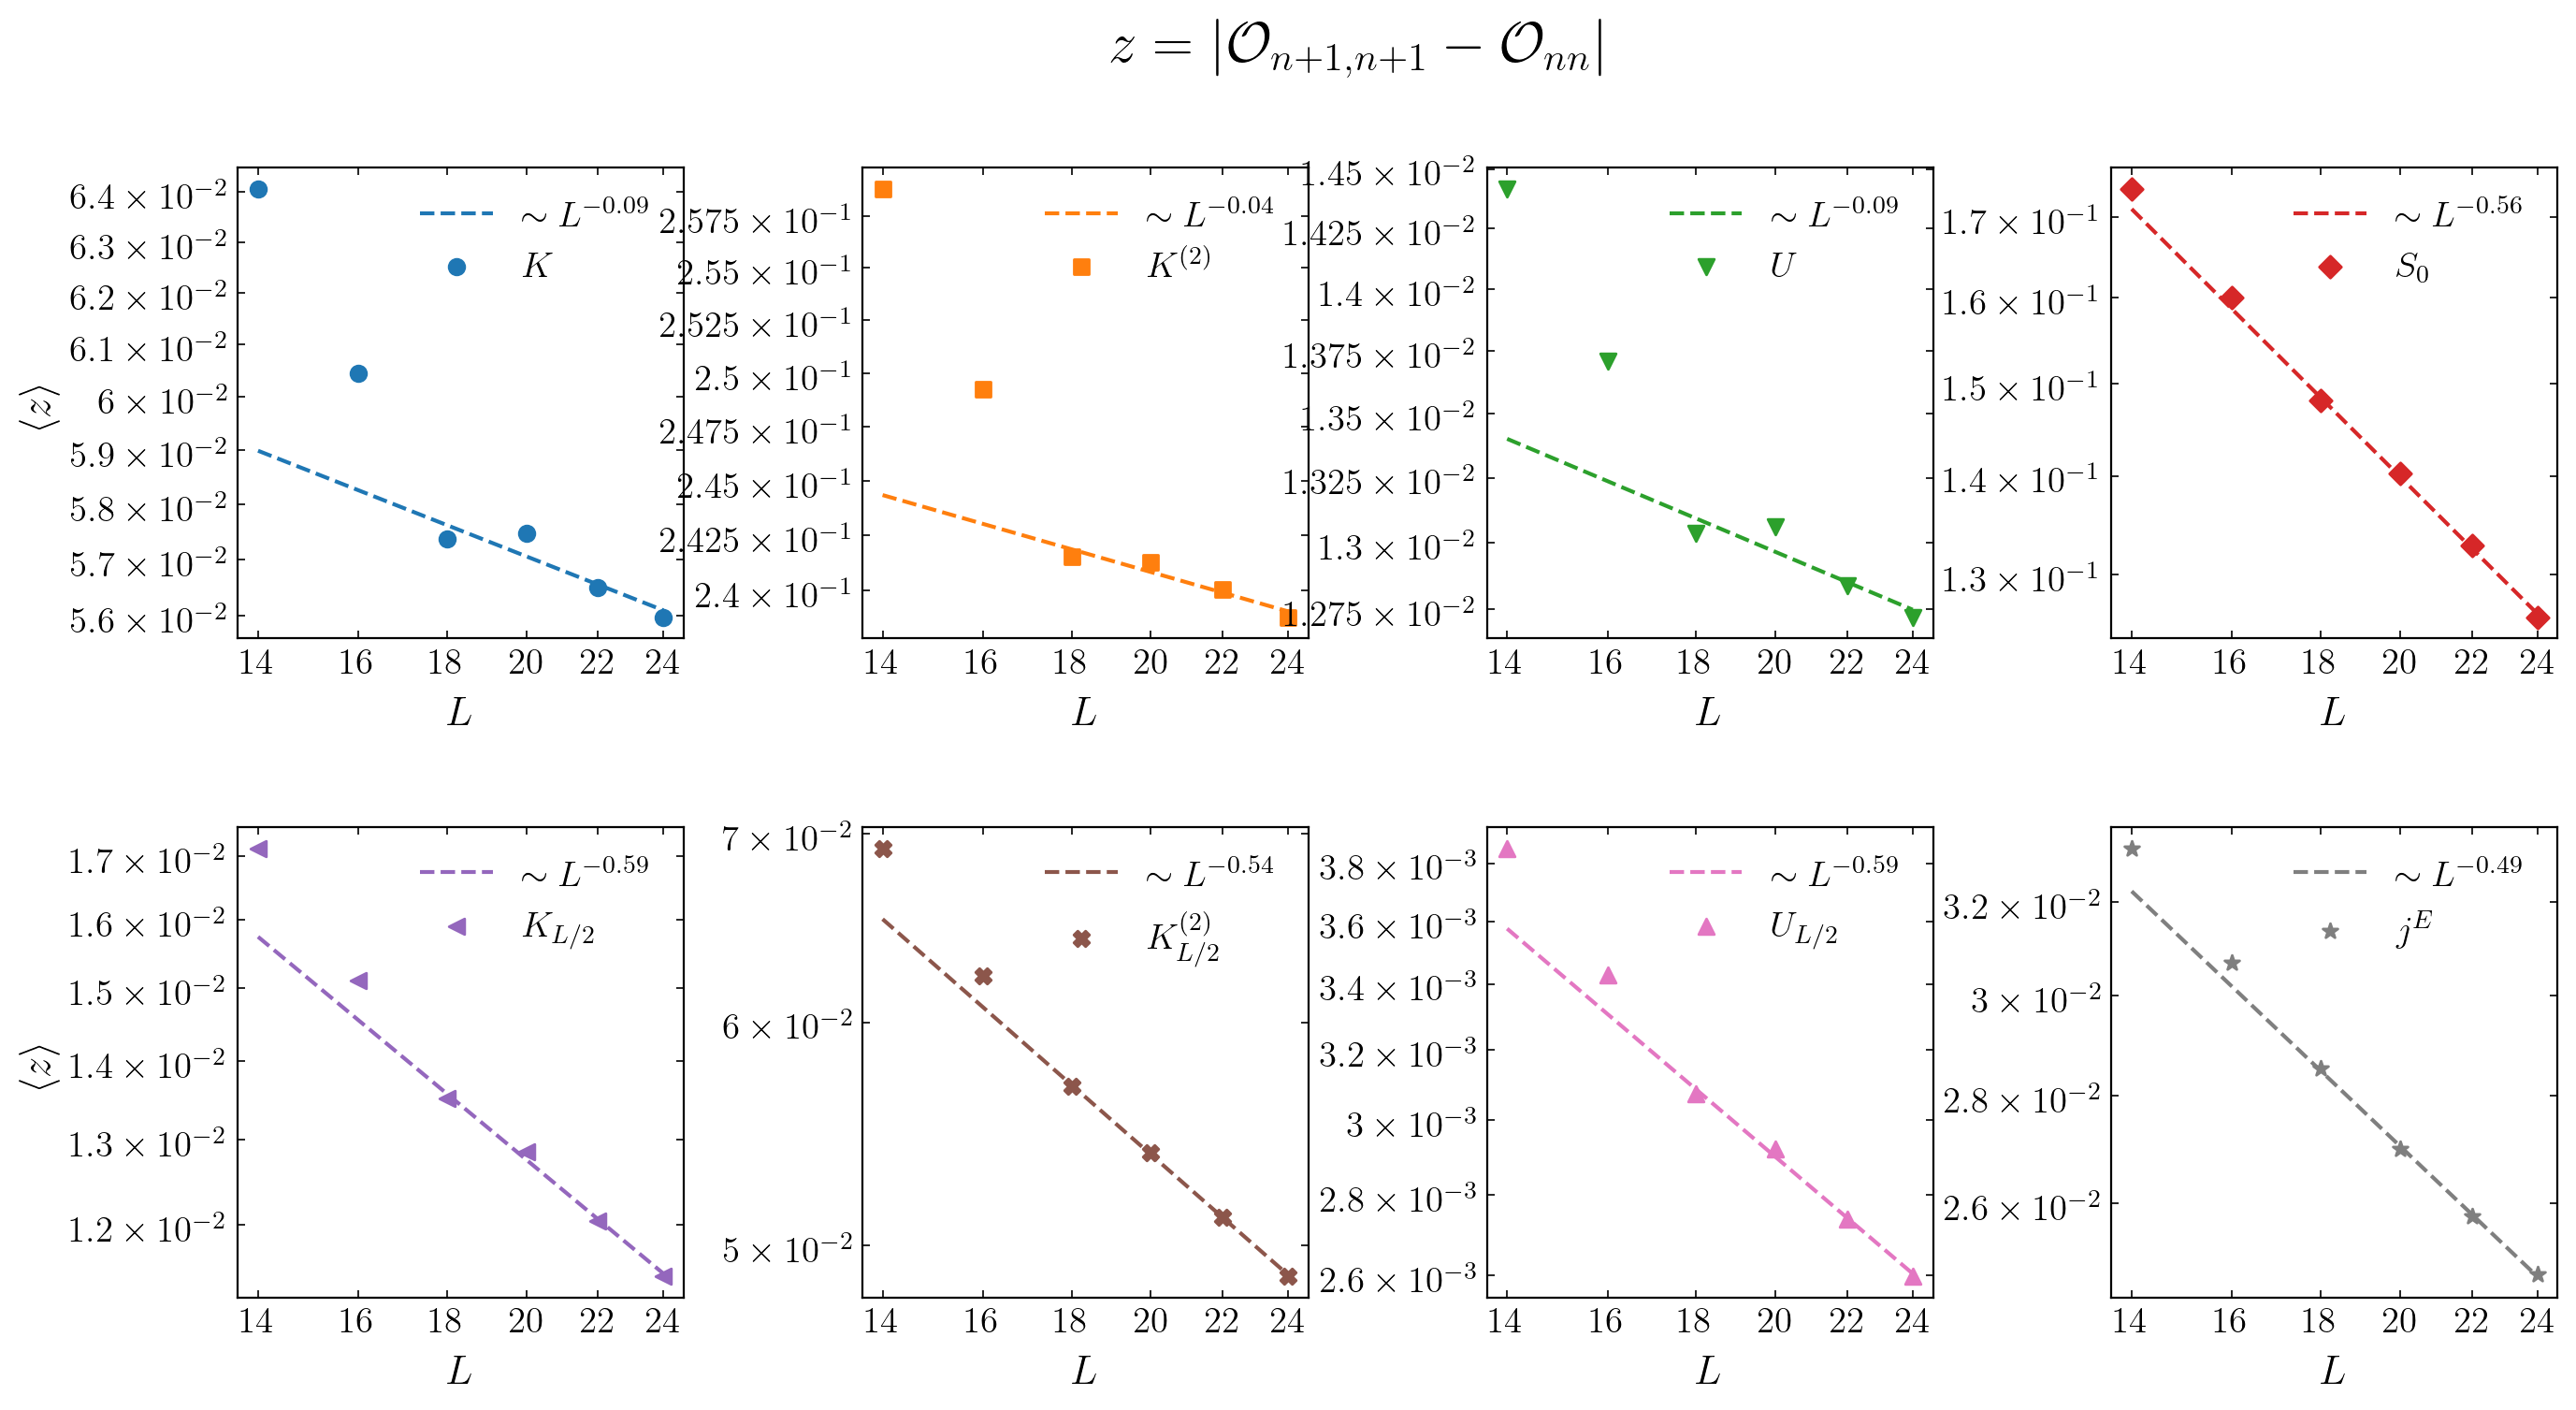

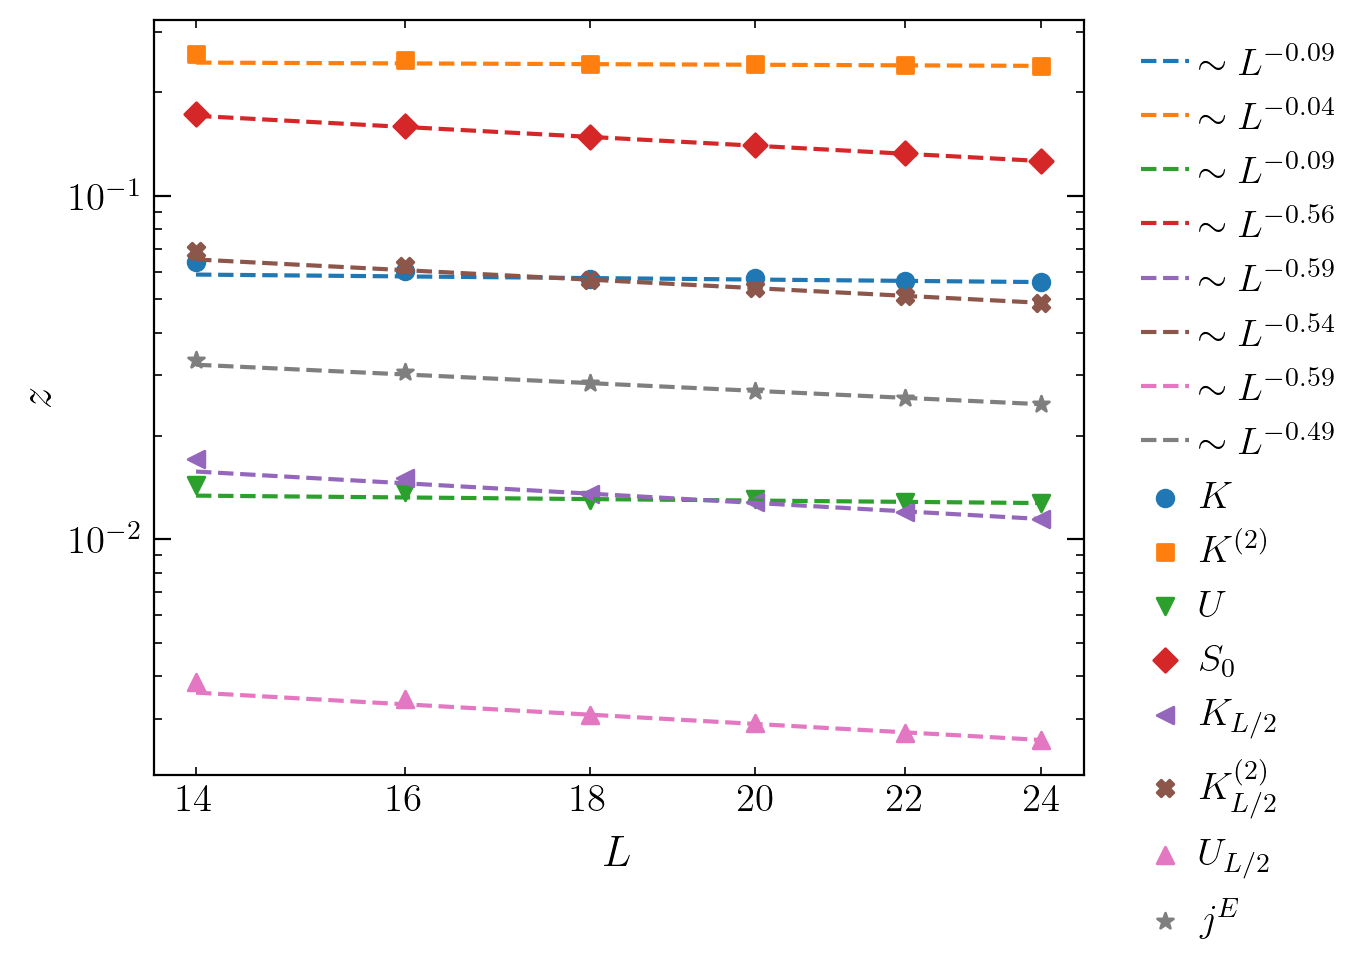

In [10]:
fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,8), dpi = 200)

axis_top = axes[0, :]
axis_bot = axes[1, :]
# axis_bot[-1].axis('off')

fig2, axis_full = plt.subplots( nrows=1, ncols=1, figsize=(6,5), dpi = 200)

L=22
J1=1.0
d1=0.55
ks=0
ps=1
zxs=1


folder_base = f'./matrix_elements/XXZ/'
folder = folder_base + BOUNDARY_COND + '/'
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

REAL_SECTORS = 0
# PLOT_SPECIFIC_SECTOR = 1

sizes = (np.arange(14, 26, 2) if REAL_SECTORS else np.arange(14, 26, 2)) if BOUNDARY_COND == 'PBC' else np.arange(12, 23, 2)

Sq0 = np.zeros(sizes.shape)
jE = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin2 = np.zeros(sizes.shape)
Int = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)
Kin2_loc = np.zeros(sizes.shape)
Int_loc = np.zeros(sizes.shape)

filenamee = folder + (f'Spacing_delta={d1}_reals.csv' if REAL_SECTORS and BOUNDARY_COND == 'PBC' else f'Spacing_delta={d1}.csv')
if exists(filenamee):
    df = pd.read_csv(filenamee)
    
    sizes = np.array(df['sizes'])
    Sq0 = np.array(df['Sq0'])
    jE = np.array(df['jE'])
    Kin = np.array(df['Kin'])
    Kin2 = np.array(df['Kin2'])
    Int = np.array(df['Int'])
    Kin_loc = np.array(df['Kin_loc'])
    Kin2_loc = np.array(df['Kin2_loc'])
    Int_loc = np.array(df['Int_loc'])
    
else:
    for ii_L, L in enumerate(sizes):
        real_sec, imag_sec = get_sectors(L, hx=0.1)
        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

        dim_tot = 0
        for [ks, ps, zxs, zzs] in real_sec if REAL_SECTORS else sects:
        # for [ks, ps, zxs, zzs] in [[0, 1, 1, 1]]:
            
            factor = 1.0 if ks == 0 or (ks == L // 2 and L%2 == 0) else 2.0
            name = f"../../XXZ/results/symmetries/" + BOUNDARY_COND + "/DiagonalMatrixElements/" + info_xxz_sym(L=L, J1=J1, delta1=d1, hz=0.0, k=ks, p=ps, zx=zxs, Sz=Sz, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0])
                    dim = energies.size
                    
                    jE_tmp = np.array(file.get('jE')[0]).view('complex')
                    if any(np.abs(np.imag(jE_tmp)) > 1e-15):    print("I hath imaginary values, that scumbag!", jE)
                    else:                                       jE_tmp = np.real(jE_tmp)
                    
                    Sq0_tmp         = np.array(file.get('Sq0')[0])    
                    Kin_tmp         = np.array(file.get('Kin')[0])
                    Kin2_tmp        = np.array(file.get('Kin2')[0])
                    Int_tmp         = np.array(file.get('Int')[0])
                    Kin_loc_tmp     = np.array(file.get('Kin_loc')[0])
                    Kin2_loc_tmp    = np.array(file.get('Kin2_loc')[0])
                    Int_loc_tmp     = np.array(file.get('Int_loc')[0])

                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                    num = 0.5 * dim

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    if num < dim and my_min > 0 and my_max < dim:
                        Sq0_tmp = np.diff(Sq0_tmp)[my_min : my_max]
                        jE_tmp = np.diff(jE_tmp)[my_min : my_max]
                        Kin_tmp = np.diff(Kin_tmp)[my_min : my_max]
                        Kin2_tmp = np.diff(Kin2_tmp)[my_min : my_max]
                        Int_tmp = np.diff(Int_tmp)[my_min : my_max]
                        Kin_loc_tmp = np.diff(Kin_loc_tmp)[my_min : my_max]
                        Kin2_loc_tmp = np.diff(Kin2_loc_tmp)[my_min : my_max]
                        Int_loc_tmp = np.diff(Int_loc_tmp)[my_min : my_max]
                    
                    jE[ii_L]        += np.sum(np.abs(jE_tmp)) * factor
                    Sq0[ii_L]       += np.sum(np.abs(Sq0_tmp)) * factor
                    Kin[ii_L]       += np.sum(np.abs(Kin_tmp)) * factor
                    Kin2[ii_L]      += np.sum(np.abs(Kin2_tmp)) * factor
                    Int[ii_L]       += np.sum(np.abs(Int_tmp)) * factor
                    Kin_loc[ii_L]   += np.sum(np.abs(Kin_loc_tmp)) * factor
                    Kin2_loc[ii_L]  += np.sum(np.abs(Kin2_loc_tmp)) * factor
                    Int_loc[ii_L]   += np.sum(np.abs(Int_loc_tmp)) * factor

            else:
                print(name)
        if dim_tot != binom(L, L//2):
            print("Missing sector:", dim_tot, binom(L, L//2))
        Sq0[ii_L]       /= dim_tot
        jE[ii_L]       /= dim_tot
        Kin[ii_L]       /= dim_tot
        Kin2[ii_L]       /= dim_tot
        Int[ii_L]       /= dim_tot
        Kin_loc[ii_L]   /= dim_tot
        Kin2_loc[ii_L]   /= dim_tot
        Int_loc[ii_L]   /= dim_tot

        print(L)
    data = {'sizes': sizes, 'Kin': Kin, 'Kin2': Kin2, 'Int': Int, 'Kin_loc': Kin_loc, 'Kin2_loc': Kin2_loc, 'Int_loc': Int_loc, 'Sq0': Sq0, 'jE': jE}
    df = pd.DataFrame(data=data)
    df.to_csv(filenamee)

def plot_data(axis, x, y, label = ""):
    sc = axis.scatter(x, rescale(sizes, y), marker=next(markers), color = next(colors), label=label)
    # print(y)
    if not any(np.isnan(y)) and not (all(np.abs(y) < 1e-14)):
        pars, pconv = fit(power_law,
                        xdata = x[-4:],
                        ydata = y[-4:])
        print(label, pars, x[-4:])
        xval = np.linspace(min(x), max(x), 100)
        axis.plot(xval, power_law(xval, *pars), ls='--', color=sc.get_facecolors()[0].tolist(), label=r"$\sim L^{%.2f}$"%pars[0])
    

def rescale(x, y):
    return y

colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)

plot_data(axis_top[0], sizes, rescale(sizes, Kin)       , label=r"$K$")
plot_data(axis_top[1], sizes, rescale(sizes, Kin2)      , label=r"$K^{(2)}$")
plot_data(axis_top[2], sizes, rescale(sizes, Int)       , label=r"$U$")
plot_data(axis_top[3], sizes, rescale(sizes, Sq0)       , label=r"$S_0$")
plot_data(axis_bot[0], sizes, rescale(sizes, Kin_loc)   , label=r"$K_{L/2}$")
plot_data(axis_bot[1], sizes, rescale(sizes, Kin2_loc)  , label=r"$K^{(2)}_{L/2}$")
plot_data(axis_bot[2], sizes, rescale(sizes, Int_loc)   , label=r"$U_{L/2}$")
plot_data(axis_bot[3], sizes, rescale(sizes, jE)        , label=r"$j^E$")

print("--------------- Repeat")
colors = itertools.cycle(colors_ls)
markers = itertools.cycle(markers_ls)
plot_data(axis_full, sizes, rescale(sizes, Kin)     , label=r"$K$")
plot_data(axis_full, sizes, rescale(sizes, Kin2)    , label=r"$K^{(2)}$")
plot_data(axis_full, sizes, rescale(sizes, Int)     , label=r"$U$")
plot_data(axis_full, sizes, rescale(sizes, Sq0)     , label=r"$S_0$")
plot_data(axis_full, sizes, rescale(sizes, Kin_loc) , label=r"$K_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Kin2_loc), label=r"$K^{(2)}_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, Int_loc) , label=r"$U_{L/2}$")
plot_data(axis_full, sizes, rescale(sizes, jE)      , label=r"$j^E$")

def make_title(title):
    return r"$\left\langle%s-\overline{%s}\right\rangle$"%(title, title)

yscale = 'log'
xscale = 'log'
fig_help.set_plot_elements(axis_top[0], ylabel=r"$\langle z\rangle$", xlabel=r"$L$",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[1], ylabel="",     xlabel=r"$L$",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[2], ylabel="",     xlabel=r"$L$",     font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_top[3], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)

fig_help.set_plot_elements(axis_bot[0], ylabel=r"$\langle z\rangle$", xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[1], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[2], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)
fig_help.set_plot_elements(axis_bot[3], ylabel="",     xlabel=r"$L$", font_size=14, set_legend=True, yscale=yscale, xscale=xscale)


fig_help.set_plot_elements(axis_full, ylabel=r"$z$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='log', xscale='log')
axis_full.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.31,1.01))

for ax in [axis_full, *axis_top, *axis_bot]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# axis_full.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
# axis_full.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

fig.suptitle(r"$z=|\mathcal{O}_{n+1,n+1}-\mathcal{O}_{nn}|$", fontsize=22)
fig.subplots_adjust(wspace = 0.4, hspace=0.4)